In [1]:
import numpy as np
import editdistance
import pandas as pd
import seaborn as sn
import tensorflow as tf
from matplotlib import pyplot as plt
from lab1_proto import plot_p_color_mesh
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [2]:
def get_model(input_dim, output_dim):
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Dense(
        256, activation='relu', use_bias=True, 
        kernel_initializer='he_uniform', input_dim=input_dim
    ))
    model.add(tf.keras.layers.Dense(
        256, activation='relu', use_bias=True, kernel_initializer='he_uniform'
    ))
    model.add(tf.keras.layers.Dense(
        256, activation='relu', use_bias=True, kernel_initializer='he_uniform'
    ))
    model.add(tf.keras.layers.Dense(
        output_dim, activation='softmax', use_bias=True, kernel_initializer='glorot_uniform'
    ))
    model.compile(optimizer='sgd', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
    return model

def get_y_label(labels, state_list):
    y = np.zeros(labels.shape)
    for i in range(len(state_list)):
        y[labels==state_list[i]] = i
    return y

def plot_trian_val(train_values, val_values, name):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    x = np.arange(0, len(train_values))
    ax.plot(train_values, color='red')
    ax.plot(val_values, color='blue')
    ax.set_xlabel('epochs')
    ax.set_title(name)
    
def merge_state2phoneme(states):
    current_state = ''
    new_states = []
    for s in states:
        ph = s[:-2]
        if ph!=current_state:
            current_state = ph
            new_states.append(ph)
    return new_states

def remove_repeat(states):
    new_states = []
    for s in states:
        new_states.append(s[:-2])
    return new_states

def merge_same_states(states):
    current_state = ''
    new_states = []
    for s in states:
        if s!=current_state:
            current_state = s
            new_states.append(s)
    return new_states

def count_correct(list1, list2):
    num_element = min(len(list1), len(list2))
    correct_counter = 0 
    for i in range(num_element):
        if list1[i] == list2[i]:
            correct_counter += 1
    return correct_counter


def get_confusion_matrix(label, predict, stateList):
    c_matrix = confusion_matrix(label, predict, labels=stateList)
    #c_matrix = np.log(c_matrix+1)   # using log(x+1) is only for better visualization
    #  reference: https://www.kaggle.com/agungor2/various-confusion-matrix-plots
    df_cm = pd.DataFrame(c_matrix, columns=stateList, index = stateList)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (100,100))
    sn.set(font_scale=1)#for label size
    sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

# perpare label

In [3]:
stateList = np.load('stateList.npy', allow_pickle=True)
print(stateList)
phonemeList = merge_state2phoneme(stateList)
print(phonemeList)
training_label = np.load('train_norm_label_labels.npy', allow_pickle=True)
val_label = np.load('val_norm_label_labels.npy', allow_pickle=True)
test_label = np.load('test_norm_label_labels.npy', allow_pickle=True)

train_y = get_y_label(training_label, stateList)
val_y = get_y_label(val_label, stateList)
test_y = get_y_label(test_label, stateList)
print(training_label.shape)
print(val_label.shape)
print(test_label.shape)
print(training_label[:10])

['ah_0' 'ah_1' 'ah_2' 'ao_0' 'ao_1' 'ao_2' 'ay_0' 'ay_1' 'ay_2' 'eh_0'
 'eh_1' 'eh_2' 'ey_0' 'ey_1' 'ey_2' 'f_0' 'f_1' 'f_2' 'ih_0' 'ih_1' 'ih_2'
 'iy_0' 'iy_1' 'iy_2' 'k_0' 'k_1' 'k_2' 'n_0' 'n_1' 'n_2' 'ow_0' 'ow_1'
 'ow_2' 'r_0' 'r_1' 'r_2' 's_0' 's_1' 's_2' 'sil_0' 'sil_1' 'sil_2' 'sp_0'
 't_0' 't_1' 't_2' 'th_0' 'th_1' 'th_2' 'uw_0' 'uw_1' 'uw_2' 'v_0' 'v_1'
 'v_2' 'w_0' 'w_1' 'w_2' 'z_0' 'z_1' 'z_2']
['ah', 'ao', 'ay', 'eh', 'ey', 'f', 'ih', 'iy', 'k', 'n', 'ow', 'r', 's', 'sil', 'sp', 't', 'th', 'uw', 'v', 'w', 'z']
(1338247,)
(169145,)
(1527014,)
['sil_0' 'sil_1' 'sil_1' 'sil_1' 'sil_1' 'sil_1' 'sil_1' 'sil_1' 'sil_1'
 'sil_1']


In [4]:
output_dim = len(stateList)
train_y = tf.keras.utils.to_categorical(train_y, output_dim)
val_y = tf.keras.utils.to_categorical(val_y, output_dim)
test_y = tf.keras.utils.to_categorical(test_y, output_dim)
print(train_y.shape)
print(val_y.shape)
print(test_y.shape)
print(output_dim)

(1338247, 61)
(169145, 61)
(1527014, 61)
61


# case1: lmfcc without dynamic features

In [5]:
train_data = np.load('train_norm_feature_lmfcc.npy', allow_pickle=True)
val_data = np.load('val_norm_feature_lmfcc.npy', allow_pickle=True)
input_dim = train_data.shape[1]
model1 = get_model(input_dim, output_dim)
history = model1.fit(train_data, train_y, validation_data=(val_data, val_y), epochs=80, batch_size=128)
model1.save("model1.h5")

Epoch 1/80
10456/10456 [==============================] - 20s 2ms/step - loss: 1.4403 - accuracy: 0.5737 - val_loss: 1.3558 - val_accuracy: 0.5899
Epoch 2/80
10456/10456 [==============================] - 21s 2ms/step - loss: 1.2613 - accuracy: 0.6127 - val_loss: 1.2751 - val_accuracy: 0.6082
Epoch 3/80
10456/10456 [==============================] - 21s 2ms/step - loss: 1.2136 - accuracy: 0.6251 - val_loss: 1.2913 - val_accuracy: 0.5880
Epoch 4/80
10456/10456 [==============================] - 20s 2ms/step - loss: 1.1853 - accuracy: 0.6329 - val_loss: 1.2452 - val_accuracy: 0.6157
Epoch 5/80
10456/10456 [==============================] - 20s 2ms/step - loss: 1.1664 - accuracy: 0.6378 - val_loss: 1.2277 - val_accuracy: 0.6139
Epoch 6/80
10456/10456 [==============================] - 20s 2ms/step - loss: 1.1518 - accuracy: 0.6422 - val_loss: 1.2527 - val_accuracy: 0.6093
Epoch 7/80
10456/10456 [==============================] - 20s 2ms/step - loss: 1.1400 - accuracy: 0.6452 - val_loss: 1

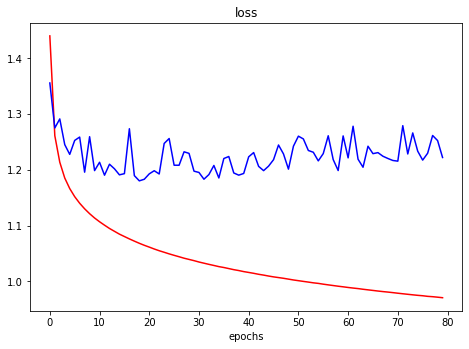

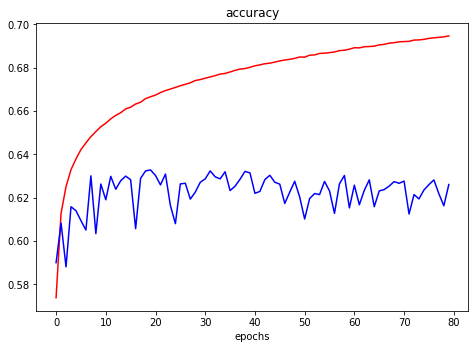

In [6]:
plot_trian_val(history.history['loss'], history.history['val_loss'], 'loss')
plot_trian_val(history.history['accuracy'], history.history['val_accuracy'], 'accuracy')

# case2: mspec without dynamic features

In [7]:
train_data = np.load('train_norm_feature_mspec.npy', allow_pickle=True)
val_data = np.load('val_norm_feature_mspec.npy', allow_pickle=True)
input_dim = train_data.shape[1]
model2 = get_model(input_dim, output_dim)
history = model2.fit(train_data, train_y, validation_data=(val_data, val_y), epochs=80, batch_size=128)
model2.save("model2.h5")

Epoch 1/80
10456/10456 [==============================] - 19s 2ms/step - loss: 1.5278 - accuracy: 0.5483 - val_loss: 1.4113 - val_accuracy: 0.5647
Epoch 2/80
10456/10456 [==============================] - 19s 2ms/step - loss: 1.3074 - accuracy: 0.6014 - val_loss: 1.4111 - val_accuracy: 0.5649
Epoch 3/80
10456/10456 [==============================] - 19s 2ms/step - loss: 1.2459 - accuracy: 0.6178 - val_loss: 1.2650 - val_accuracy: 0.6075
Epoch 4/80
10456/10456 [==============================] - 19s 2ms/step - loss: 1.2079 - accuracy: 0.6276 - val_loss: 1.2616 - val_accuracy: 0.6105
Epoch 5/80
10456/10456 [==============================] - 20s 2ms/step - loss: 1.1810 - accuracy: 0.6348 - val_loss: 1.4050 - val_accuracy: 0.5748
Epoch 6/80
10456/10456 [==============================] - 19s 2ms/step - loss: 1.1604 - accuracy: 0.6404 - val_loss: 1.2202 - val_accuracy: 0.6212
Epoch 7/80
10456/10456 [==============================] - 19s 2ms/step - loss: 1.1436 - accuracy: 0.6451 - val_loss: 1

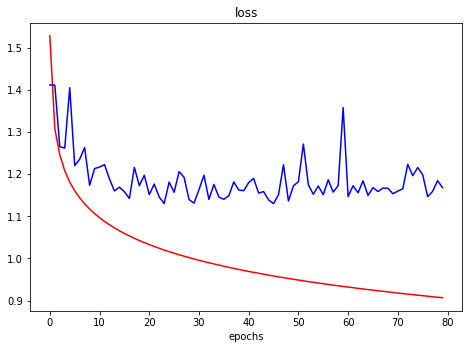

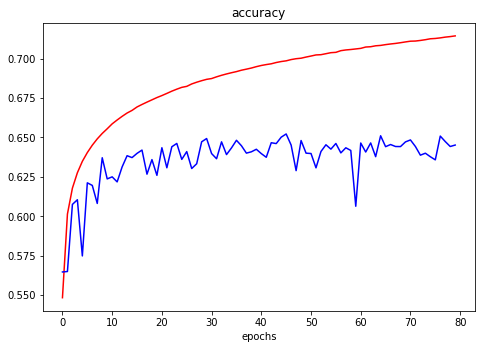

In [8]:
plot_trian_val(history.history['loss'], history.history['val_loss'], 'loss')
plot_trian_val(history.history['accuracy'], history.history['val_accuracy'], 'accuracy')

# case3: mfcc with dynamic features

In [9]:
train_data = np.load('train_norm_feature_dylmfcc.npy', allow_pickle=True)
val_data = np.load('val_norm_feature_dylmfcc.npy', allow_pickle=True)
input_dim = train_data.shape[1]
model3 = get_model(input_dim, output_dim)
history = model3.fit(train_data, train_y, validation_data=(val_data, val_y), epochs=80, batch_size=128)
model3.save("model3.h5")

Epoch 1/80
10456/10456 [==============================] - 19s 2ms/step - loss: 1.1035 - accuracy: 0.6629 - val_loss: 0.9848 - val_accuracy: 0.6764
Epoch 2/80
10456/10456 [==============================] - 19s 2ms/step - loss: 0.8269 - accuracy: 0.7337 - val_loss: 0.8316 - val_accuracy: 0.7368
Epoch 3/80
10456/10456 [==============================] - 19s 2ms/step - loss: 0.7562 - accuracy: 0.7545 - val_loss: 0.7722 - val_accuracy: 0.7501
Epoch 4/80
10456/10456 [==============================] - 19s 2ms/step - loss: 0.7134 - accuracy: 0.7667 - val_loss: 0.9278 - val_accuracy: 0.6869
Epoch 5/80
10456/10456 [==============================] - 19s 2ms/step - loss: 0.6830 - accuracy: 0.7756 - val_loss: 0.9602 - val_accuracy: 0.6675
Epoch 6/80
10456/10456 [==============================] - 19s 2ms/step - loss: 0.6596 - accuracy: 0.7828 - val_loss: 0.7436 - val_accuracy: 0.7603
Epoch 7/80
10456/10456 [==============================] - 19s 2ms/step - loss: 0.6411 - accuracy: 0.7881 - val_loss: 0

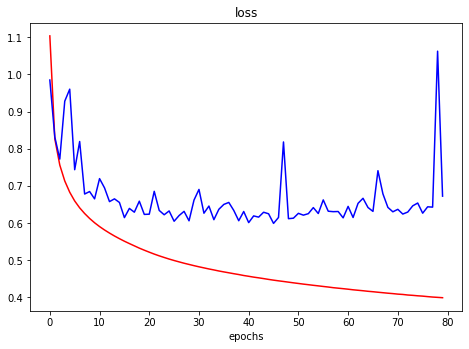

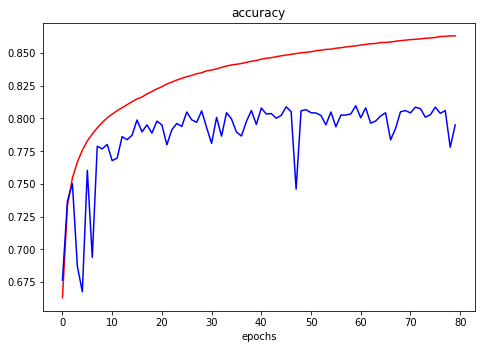

In [10]:
plot_trian_val(history.history['loss'], history.history['val_loss'], 'loss')
plot_trian_val(history.history['accuracy'], history.history['val_accuracy'], 'accuracy')

# case4: mspec with dynamic features

In [11]:
train_data = np.load('train_norm_feature_dymspec.npy', allow_pickle=True)
val_data = np.load('val_norm_feature_dymspec.npy', allow_pickle=True)
input_dim = train_data.shape[1]
model4 = get_model(input_dim, output_dim)
history = model4.fit(train_data, train_y, validation_data=(val_data, val_y), epochs=80, batch_size=128)
model4.save("model4.h5")

Epoch 1/80
10456/10456 [==============================] - 19s 2ms/step - loss: 1.0973 - accuracy: 0.6617 - val_loss: 1.0196 - val_accuracy: 0.6714
Epoch 2/80
10456/10456 [==============================] - 19s 2ms/step - loss: 0.8206 - accuracy: 0.7356 - val_loss: 0.8372 - val_accuracy: 0.7291
Epoch 3/80
10456/10456 [==============================] - 20s 2ms/step - loss: 0.7508 - accuracy: 0.7556 - val_loss: 1.0280 - val_accuracy: 0.6610
Epoch 4/80
10456/10456 [==============================] - 19s 2ms/step - loss: 0.7100 - accuracy: 0.7673 - val_loss: 0.8991 - val_accuracy: 0.7253
Epoch 5/80
10456/10456 [==============================] - 19s 2ms/step - loss: 0.6813 - accuracy: 0.7758 - val_loss: 0.7014 - val_accuracy: 0.7707
Epoch 6/80
10456/10456 [==============================] - 19s 2ms/step - loss: 0.6591 - accuracy: 0.7824 - val_loss: 0.7274 - val_accuracy: 0.7645
Epoch 7/80
10456/10456 [==============================] - 19s 2ms/step - loss: 0.6413 - accuracy: 0.7876 - val_loss: 0

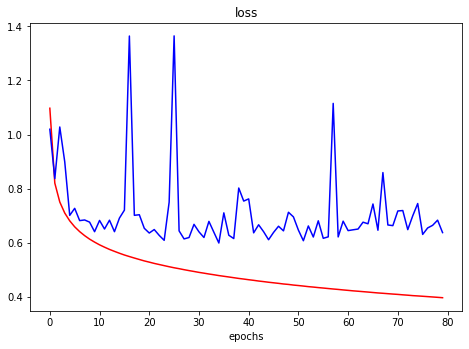

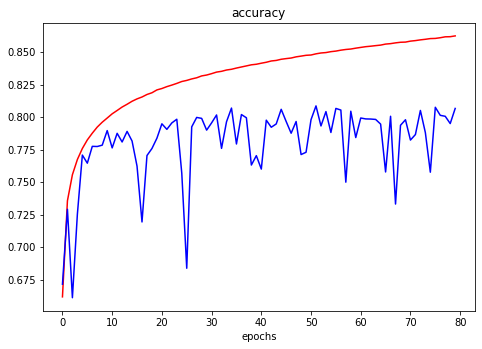

In [12]:
plot_trian_val(history.history['loss'], history.history['val_loss'], 'loss')
plot_trian_val(history.history['accuracy'], history.history['val_accuracy'], 'accuracy')

# Detailed Evaluation

In [5]:
def evauluation(case_num, feature_type):
    test_data = np.load('test_norm_feature_%s.npy'%feature_type, allow_pickle=True)[:20000]
    test_model = tf.keras.models.load_model('model%d.h5'%case_num)
    predict_y = test_model.predict(test_data)
    predict_y_label = np.argmax(predict_y, axis=-1)
    plot_p_color_mesh(predict_y[:100,:], 'prediction')
    predict_y_label = [stateList[x] for x in predict_y_label]
    num_correct = count_correct(label_test_y, predict_y_label)
    num_label = len(label_test_y)
    print('total testset size:', len(label_test_y))
    print('5.1 count correct frames at frame level:')
    print('num of label: %d'%num_label)
    print('correct predict: %d'%num_correct)
    print('accuracy:%f'%(num_correct/num_label))
    get_confusion_matrix(label_test_y, predict_y_label, stateList)

    print('\n5.2 merge all states the correspond to the same phoneme:')
    phone_predict_y = remove_repeat(predict_y_label)
    num_correct = count_correct(phone_label_y, phone_predict_y)
    print('num of label at phoneme level:')
    print('num of label: %d'%len(phone_label_y))
    print('num of predict: %d'%len(phone_predict_y))
    print('correct predict: %d'% num_correct)
    print('accuract: %f'%(num_correct/len(phone_label_y)))
    get_confusion_matrix(phone_label_y, phone_predict_y, phonemeList)
    
    
    print('\n5.3 edit distance at state level:')
    identical_predict_y = merge_same_states(predict_y_label)
    per = editdistance.eval(identical_label_y, identical_predict_y)/len(identical_label_y)
    print('phone error rate at state level:', per)
    
    print('\n5.4 edit distance at phoneme level:')
    identical_predict_phone_y = merge_same_states(phone_predict_y)
    ph_per = editdistance.eval(identical_predict_phone_y, phone_label_y)/len(phone_label_y)
    print('phone error rate at phoneme level:', ph_per)
    


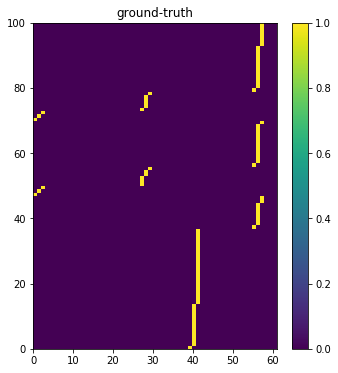

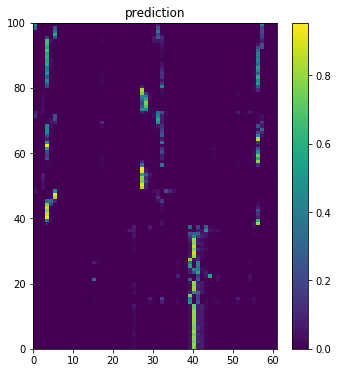

total testset size: 20000
5.1 count correct frames at frame level:
num of label: 20000
correct predict: 11193
accuracy:0.559650

5.2 merge all states the correspond to the same phoneme:
num of label at phoneme level:
num of label: 20000
num of predict: 20000
correct predict: 12877
accuract: 0.643850

5.3 edit distance at state level:
phone error rate at state level: 1.1517321016166282

5.4 edit distance at phoneme level:
phone error rate at phoneme level: 0.88605


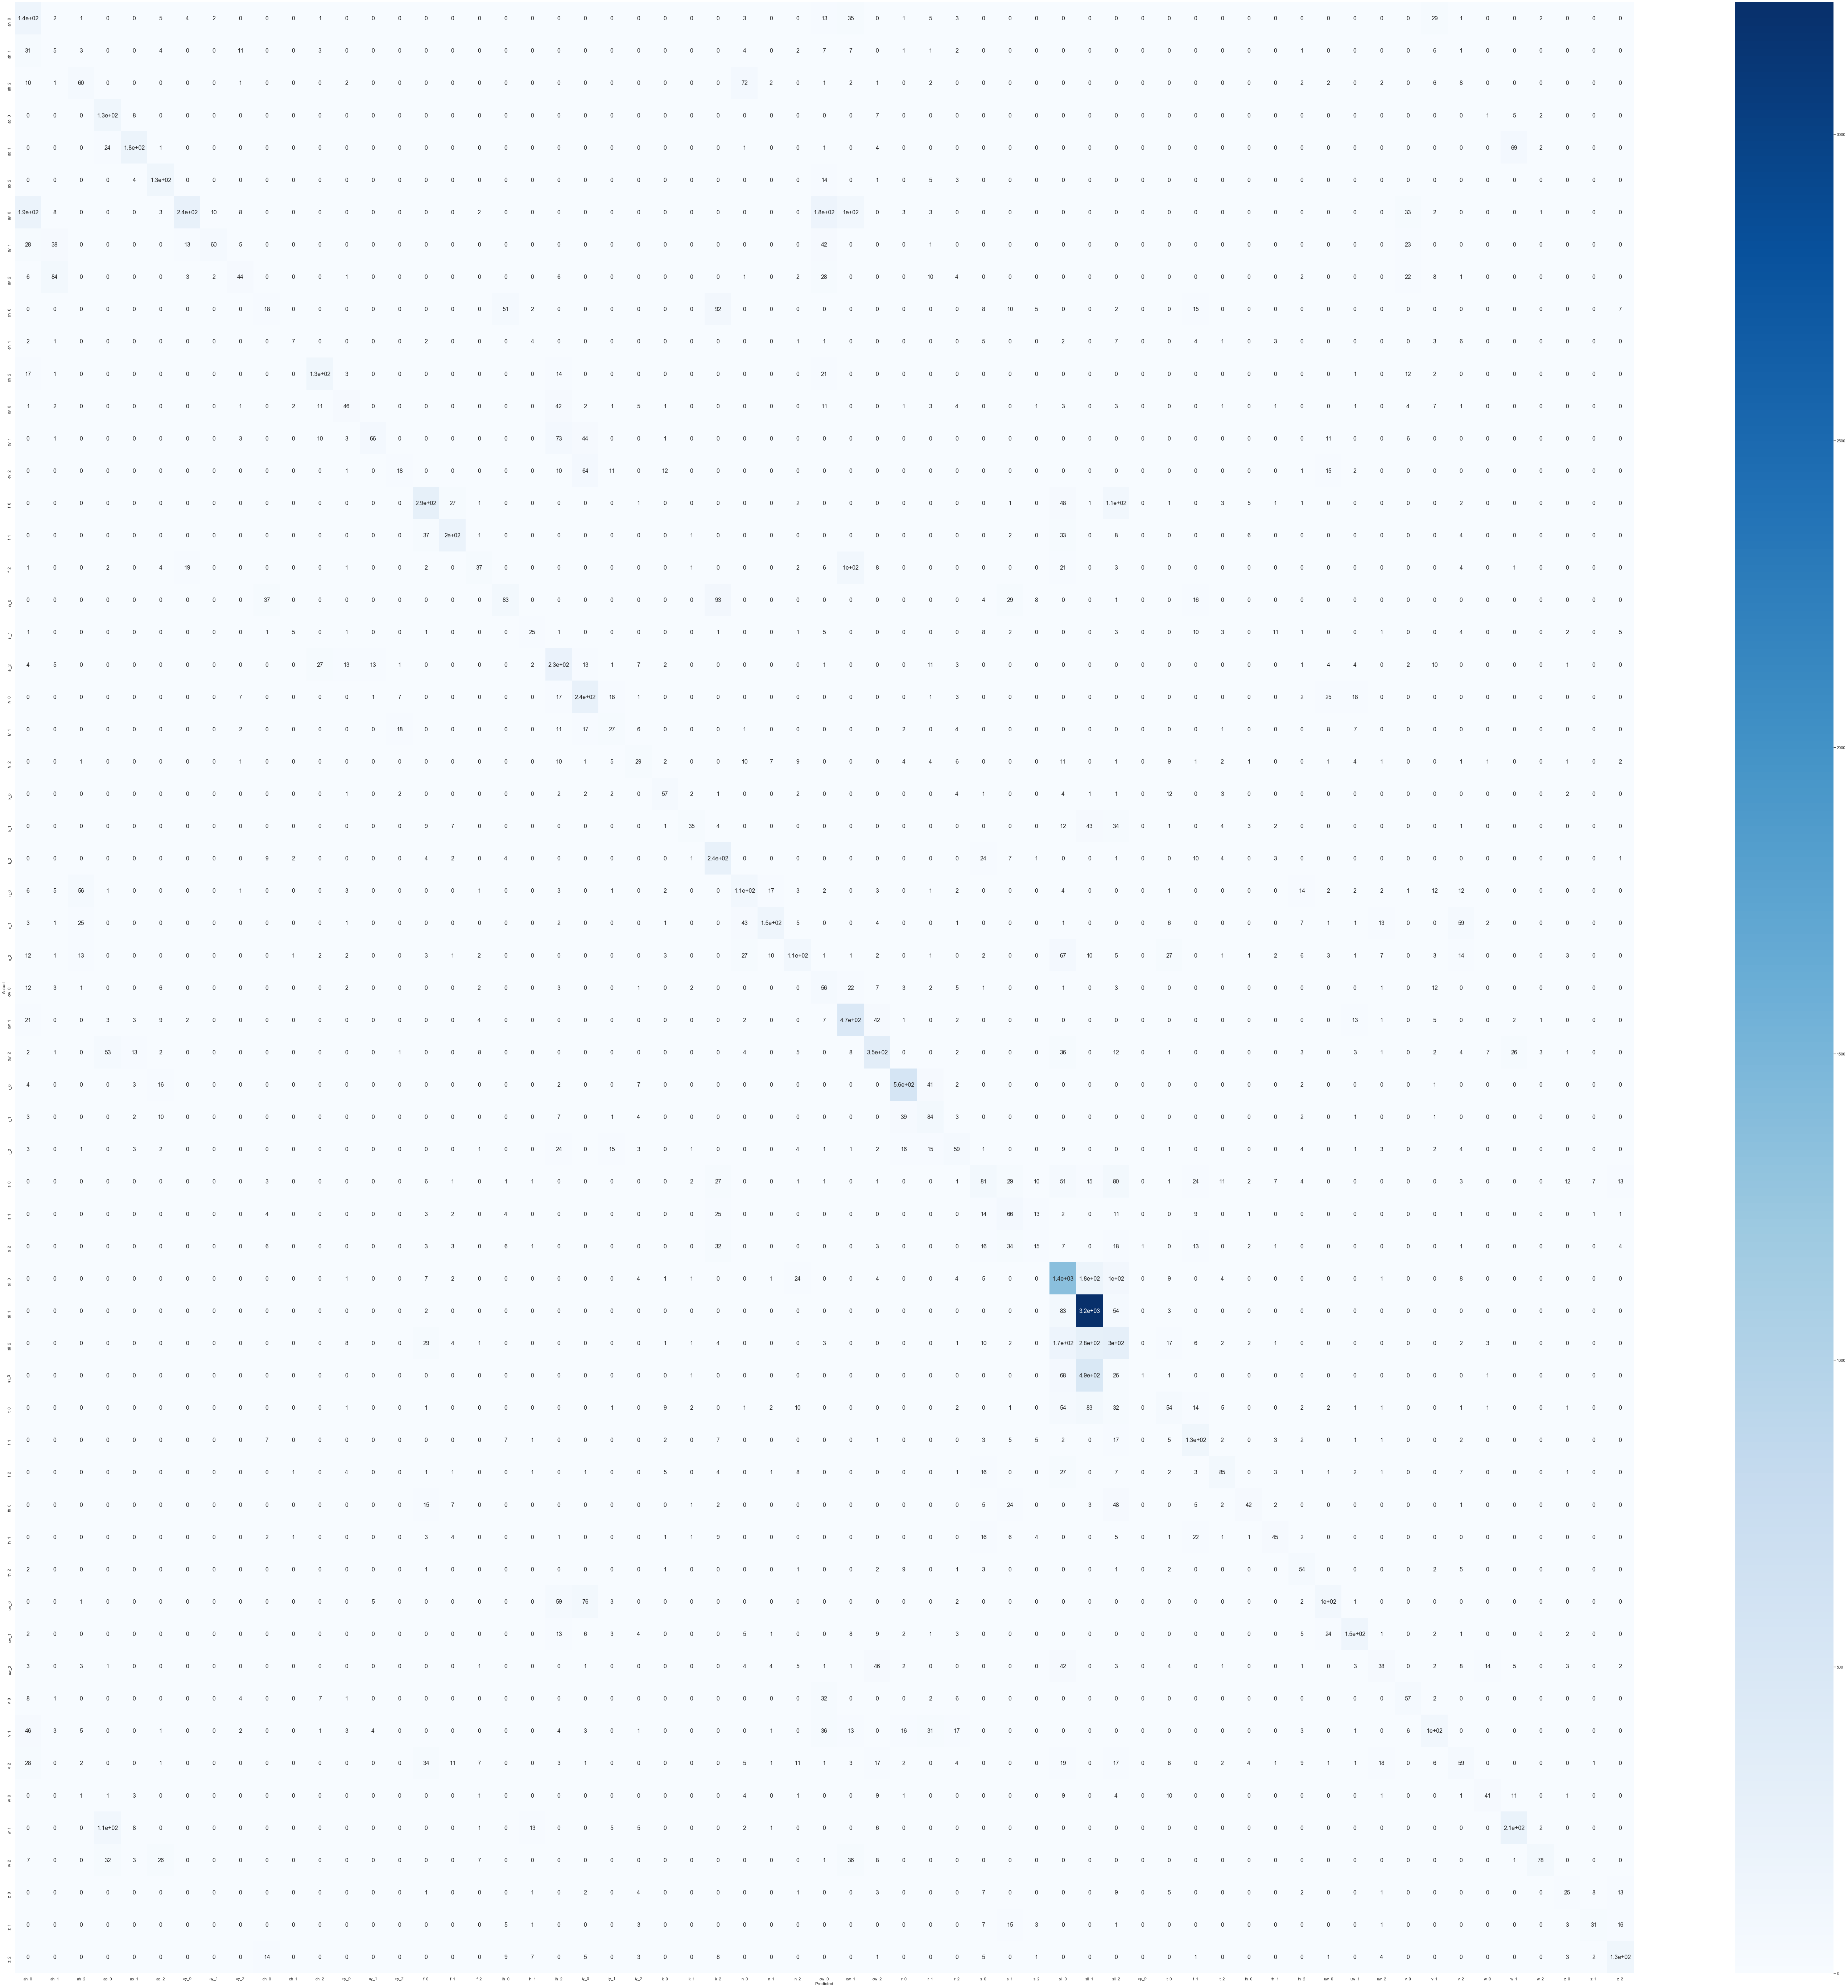

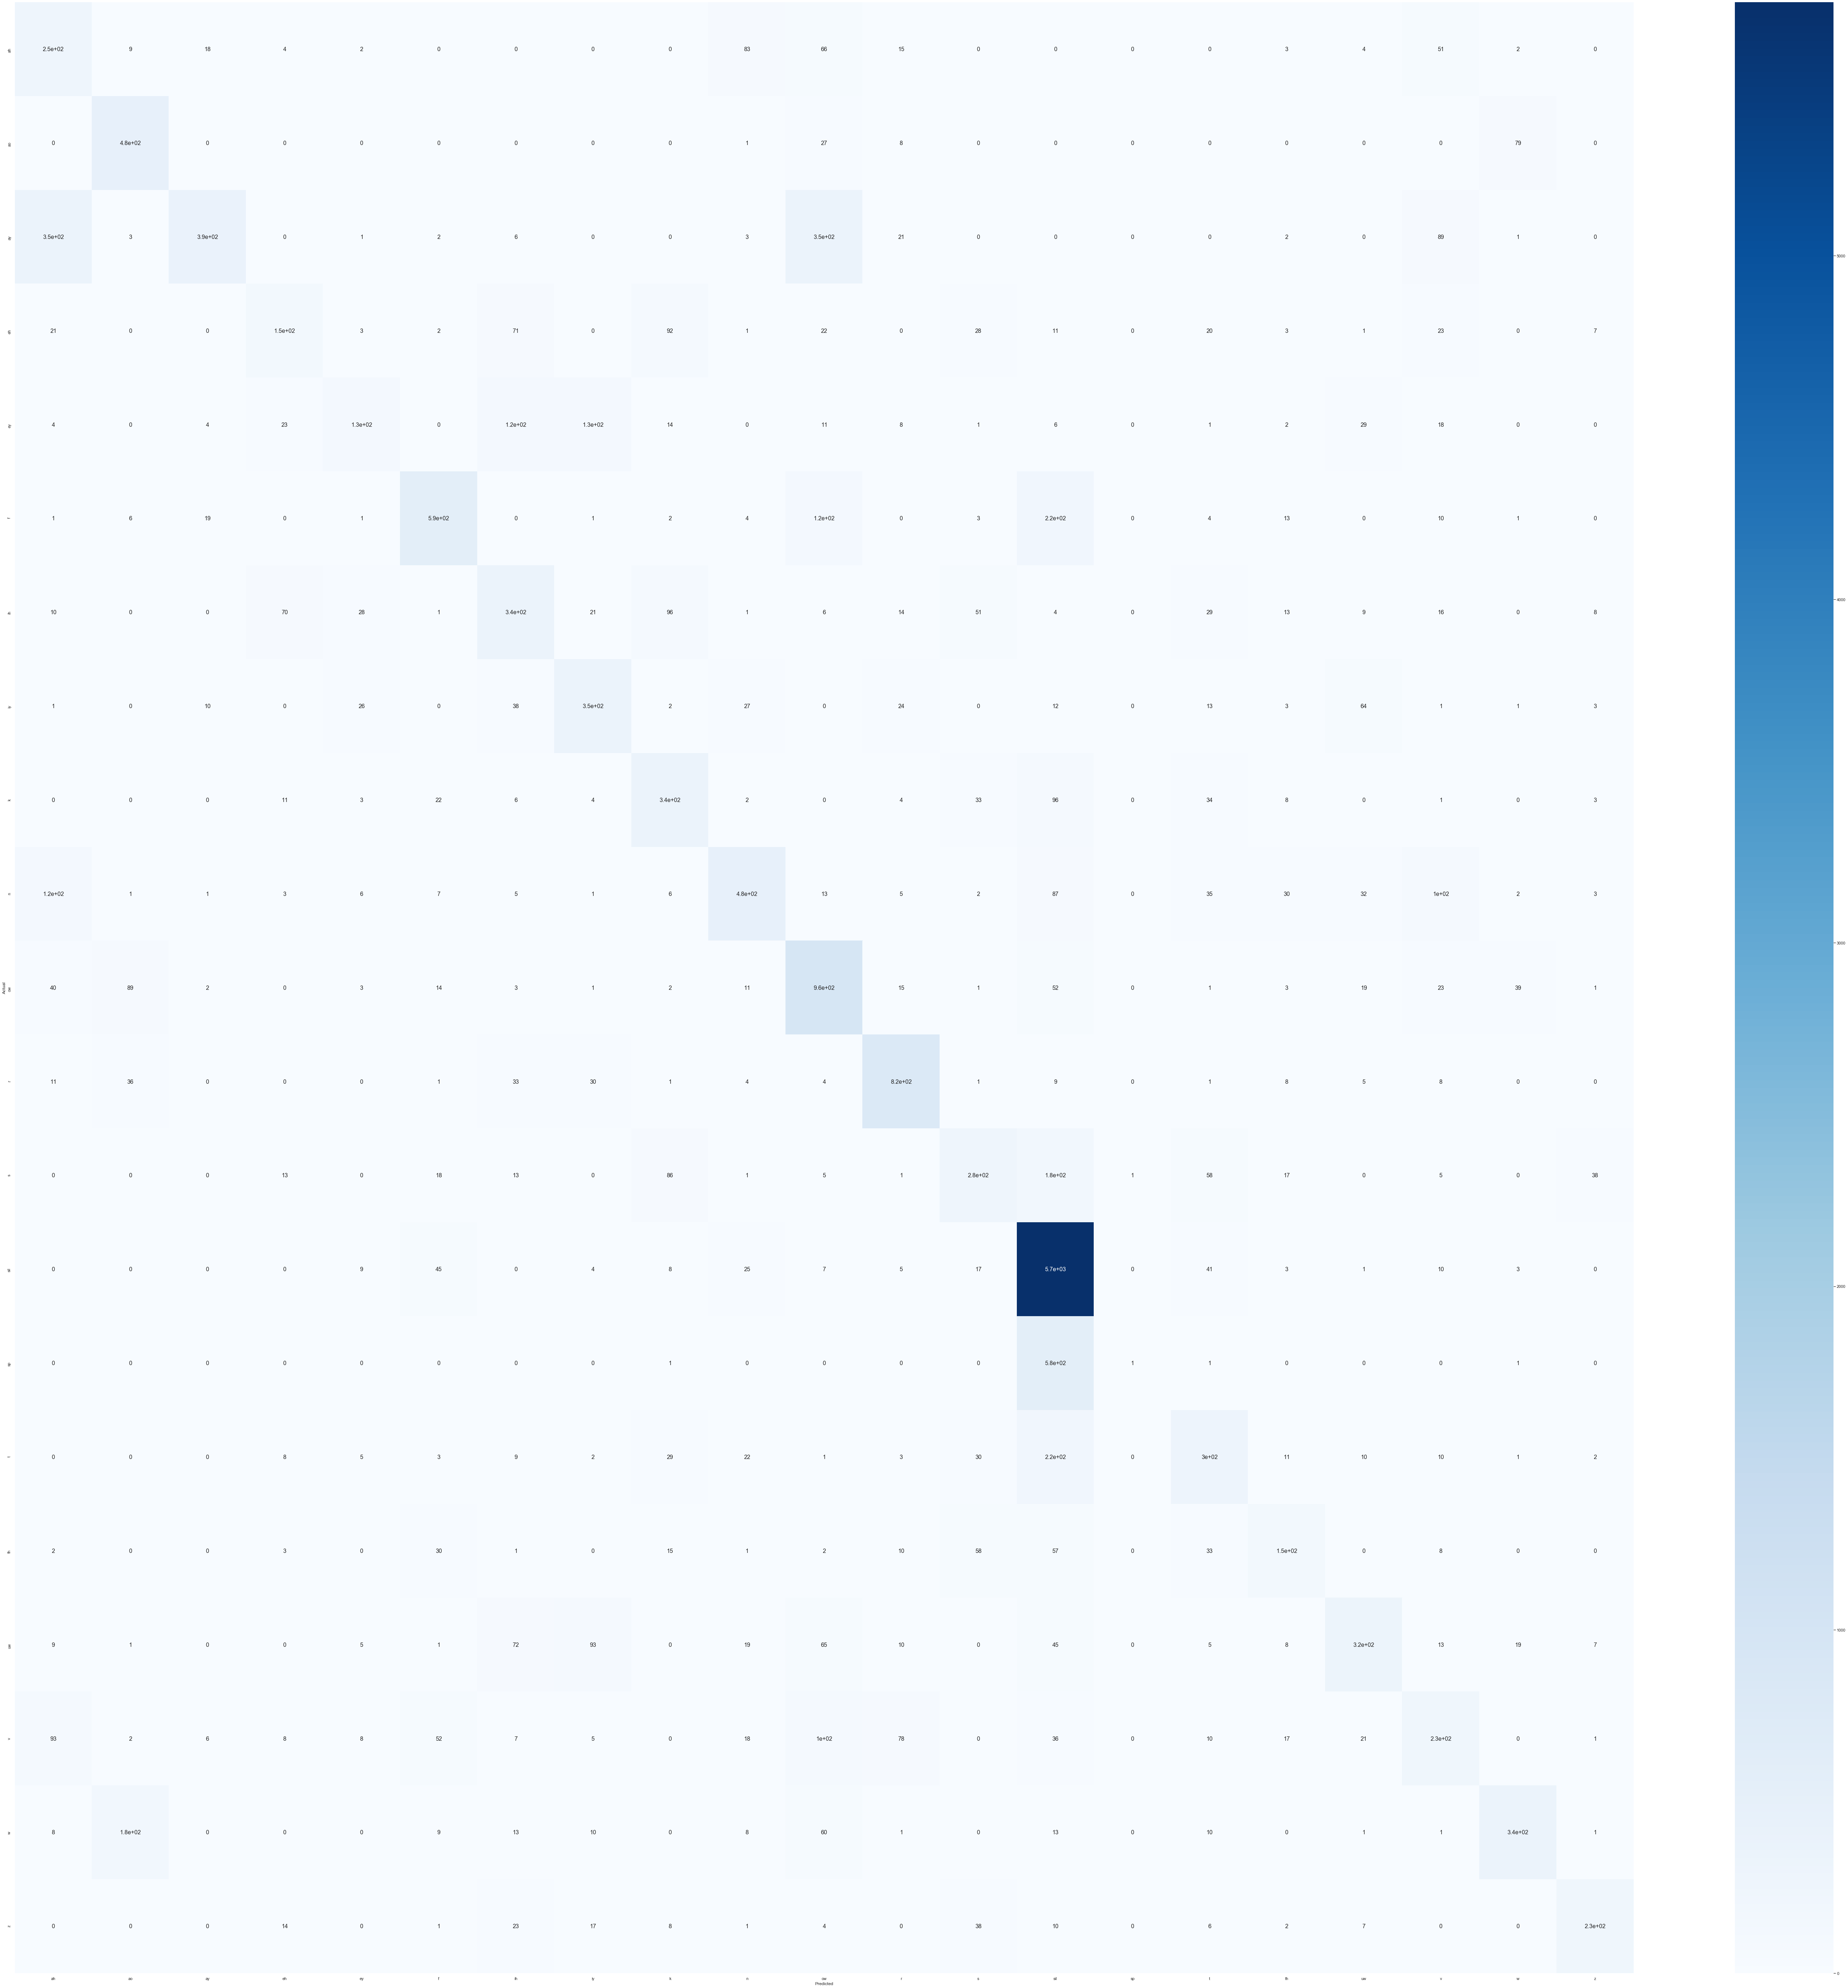

In [6]:
label_test_y = np.load('test_norm_label_labels.npy')[:20000]
merged_label_y = merge_state2phoneme(label_test_y)
phone_label_y = remove_repeat(label_test_y)
identical_label_y = merge_same_states(label_test_y)
plot_p_color_mesh(test_y[:100, :],'ground-truth')

evauluation(1, 'lmfcc')

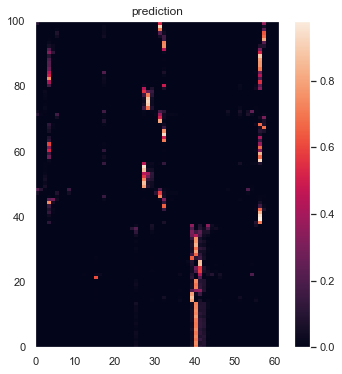

total testset size: 20000
5.1 count correct frames at frame level:
num of label: 20000
correct predict: 11372
accuracy:0.568600

5.2 merge all states the correspond to the same phoneme:
num of label at phoneme level:
num of label: 20000
num of predict: 20000
correct predict: 13221
accuract: 0.661050

5.3 edit distance at state level:
phone error rate at state level: 1.1078521939953812

5.4 edit distance at phoneme level:
phone error rate at phoneme level: 0.8867


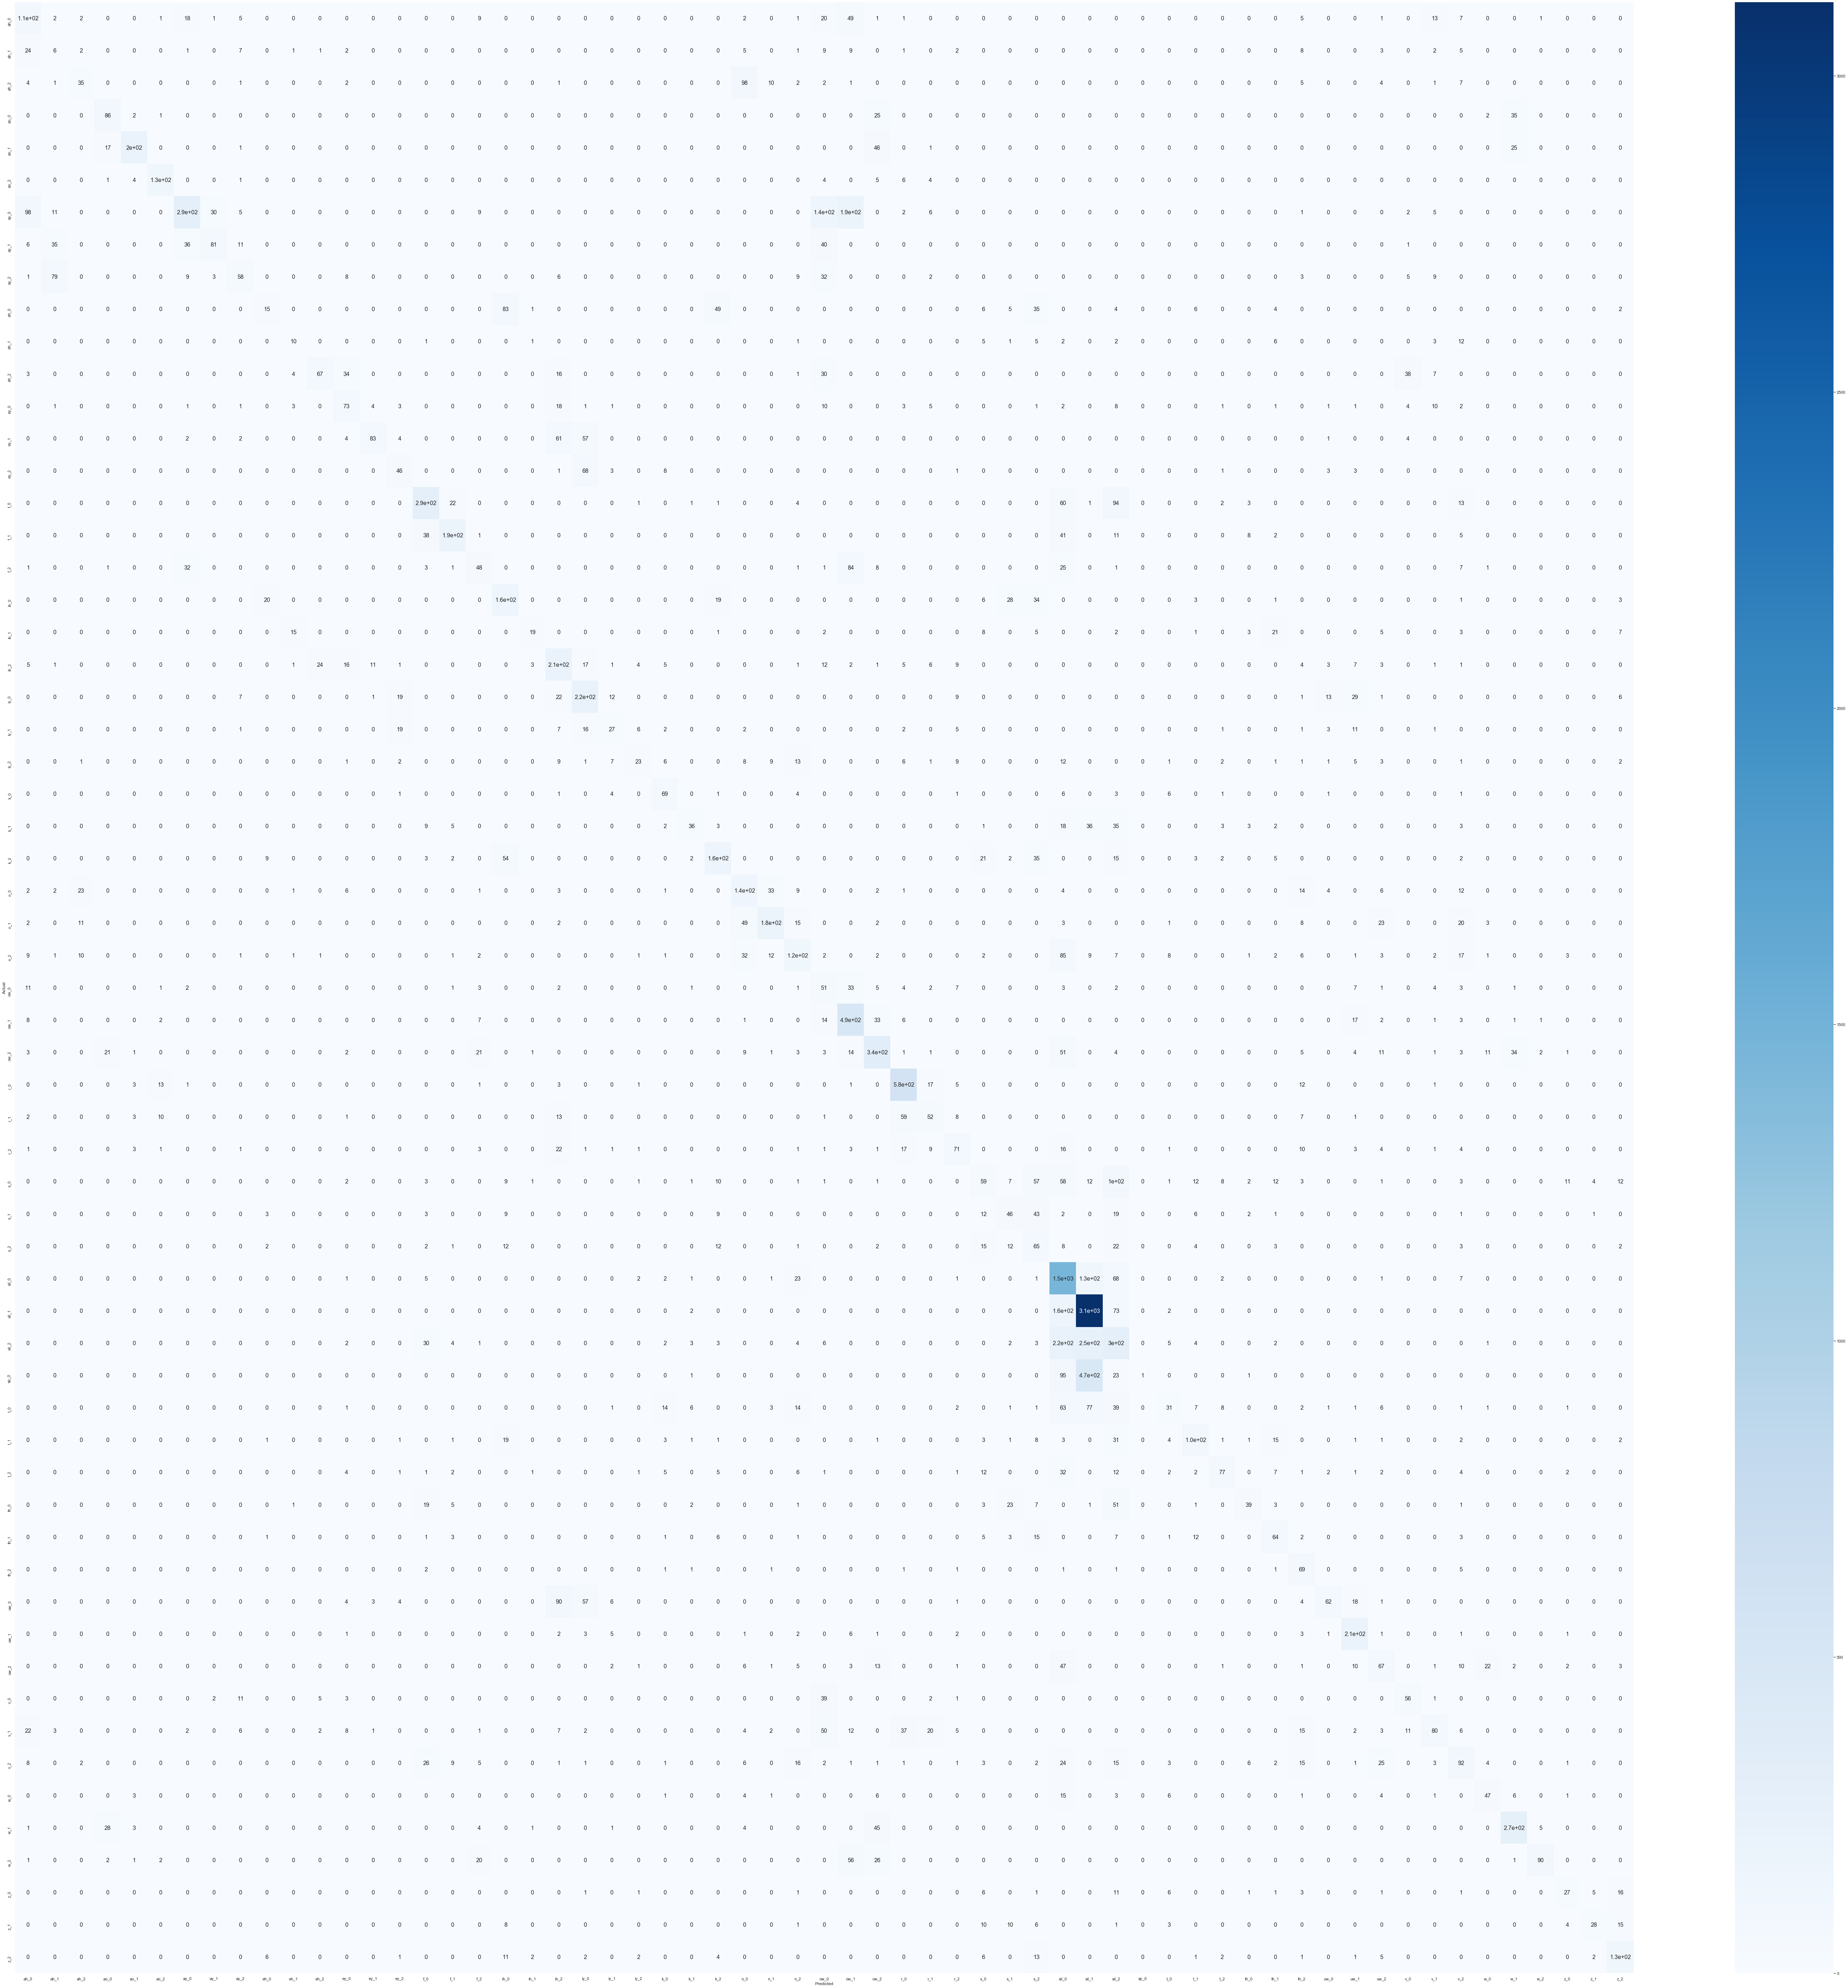

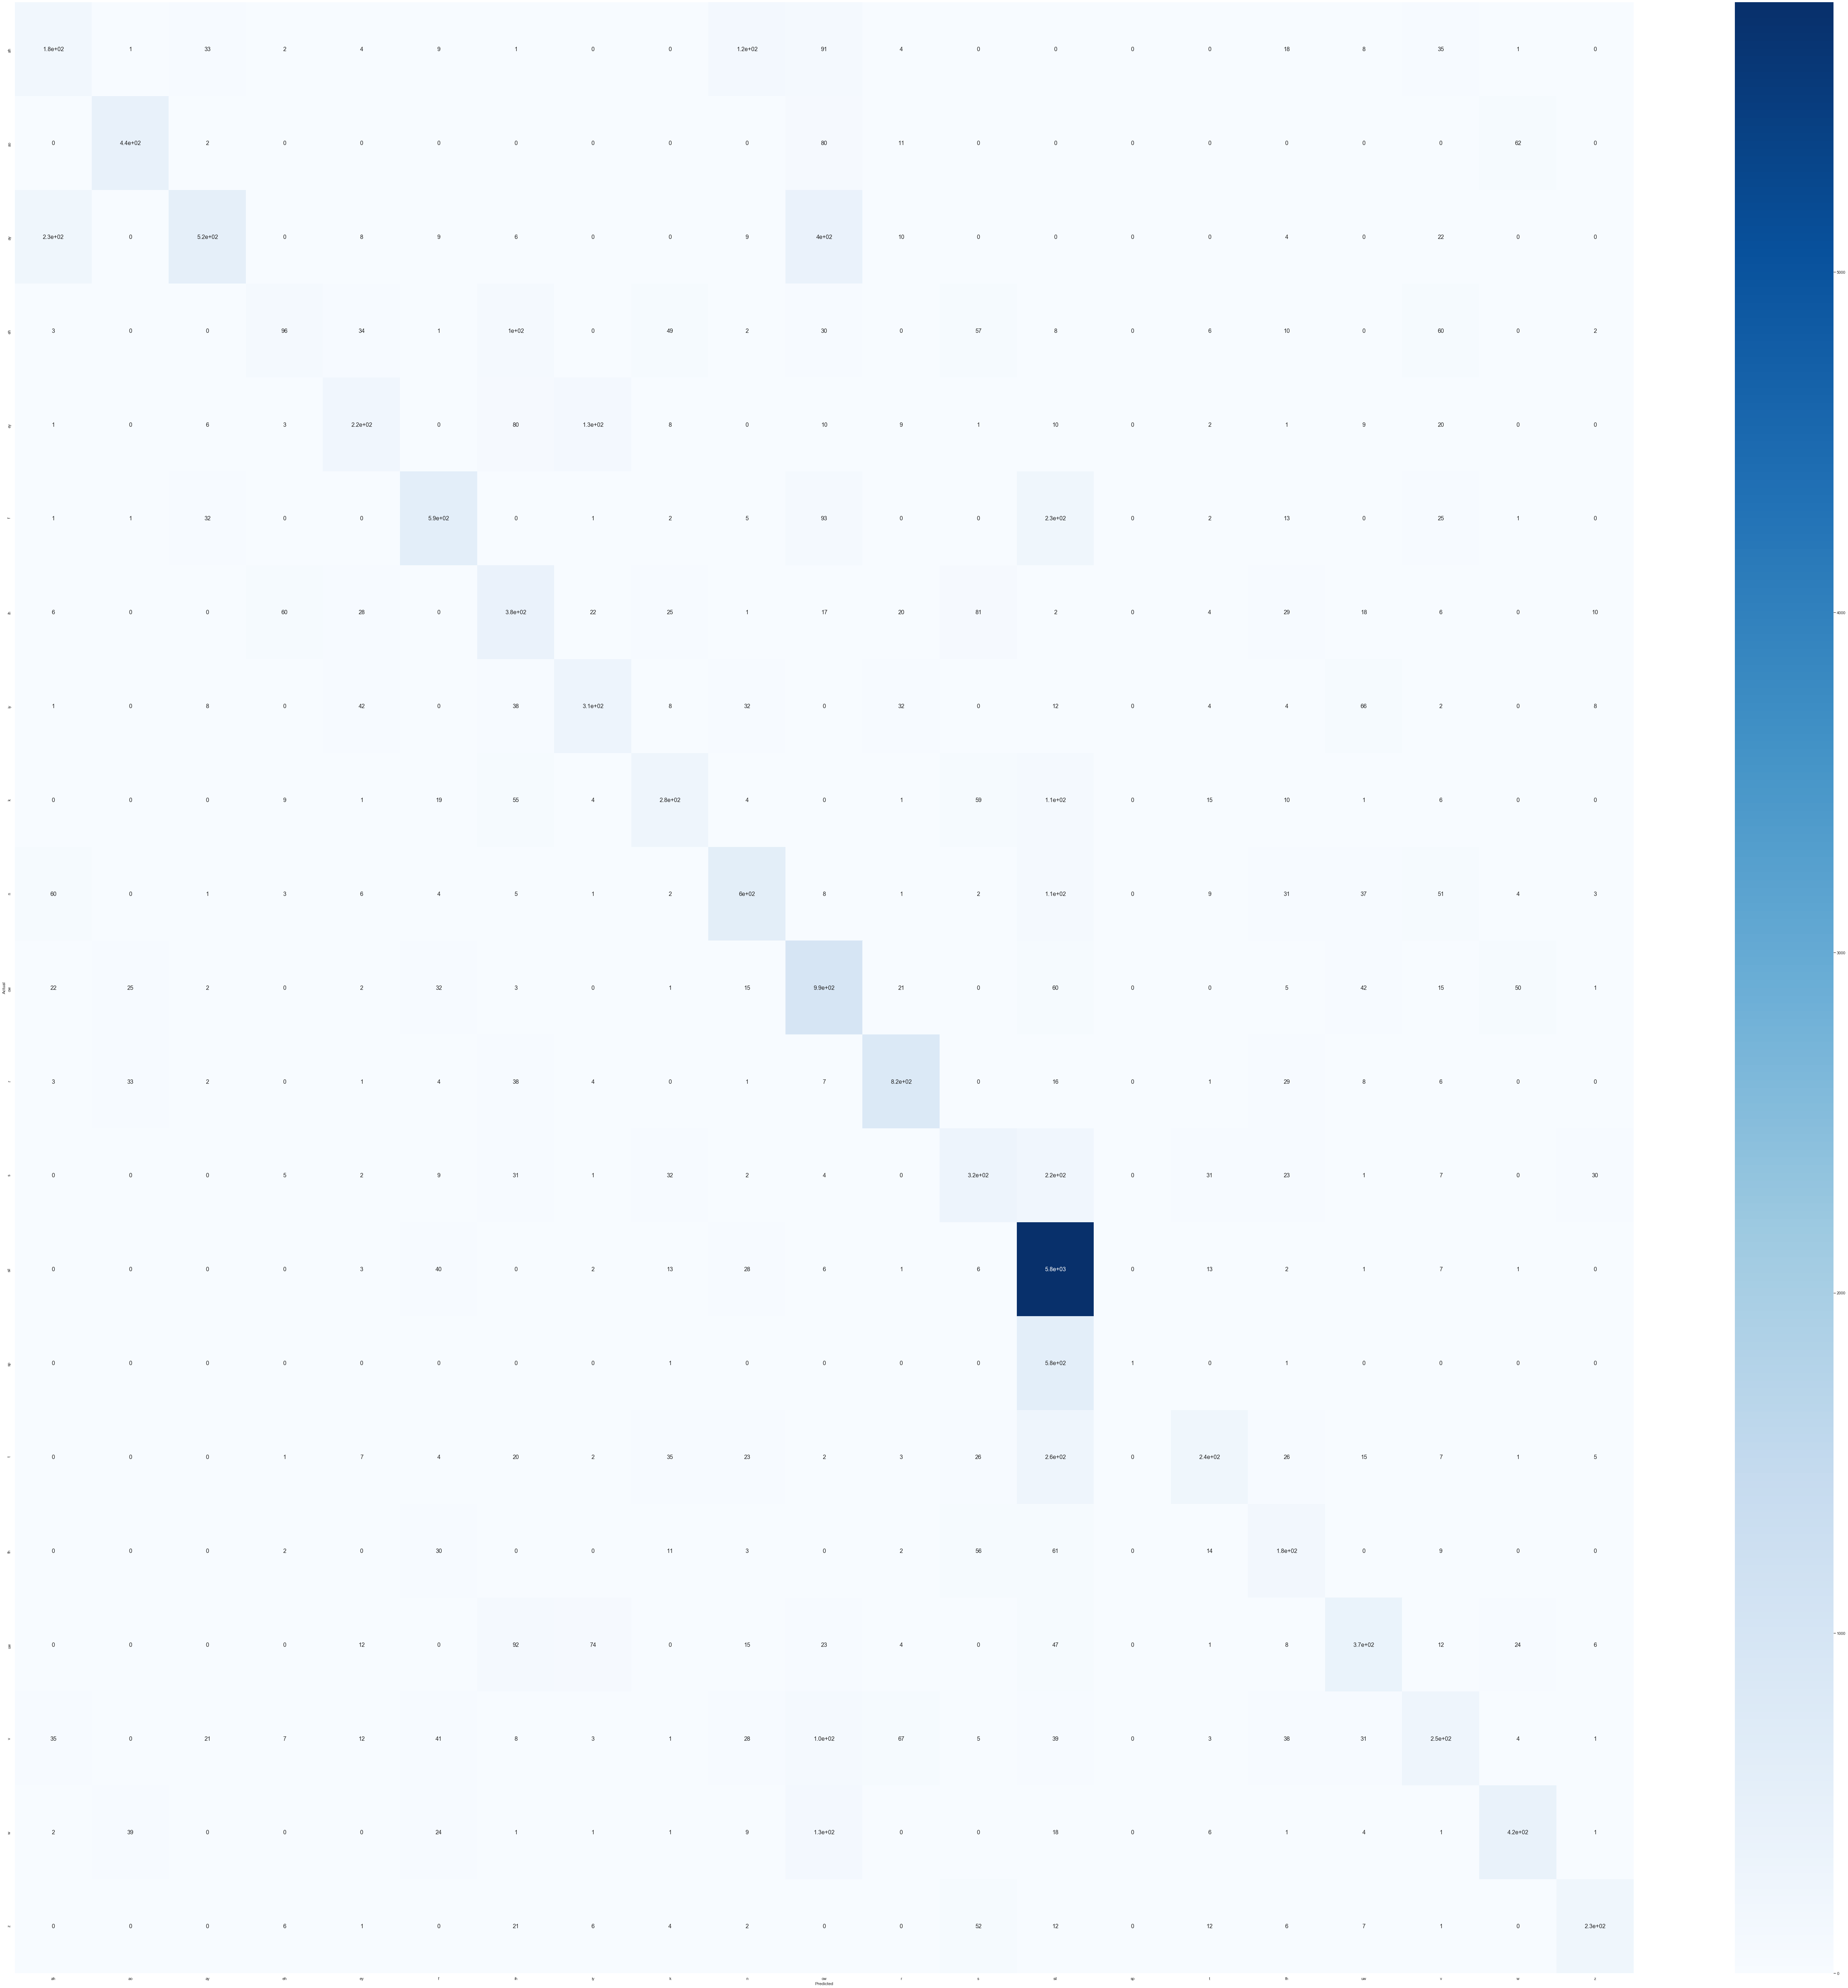

In [7]:
evauluation(2, 'mspec')

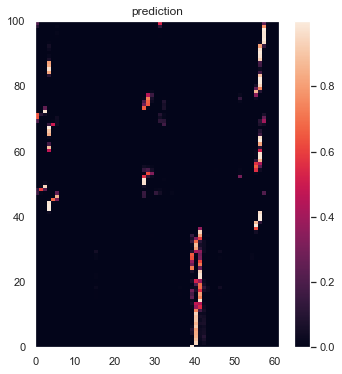

total testset size: 20000
5.1 count correct frames at frame level:
num of label: 20000
correct predict: 14269
accuracy:0.713450

5.2 merge all states the correspond to the same phoneme:
num of label at phoneme level:
num of label: 20000
num of predict: 20000
correct predict: 16102
accuract: 0.805100

5.3 edit distance at state level:
phone error rate at state level: 0.5676674364896074

5.4 edit distance at phoneme level:
phone error rate at phoneme level: 0.9052


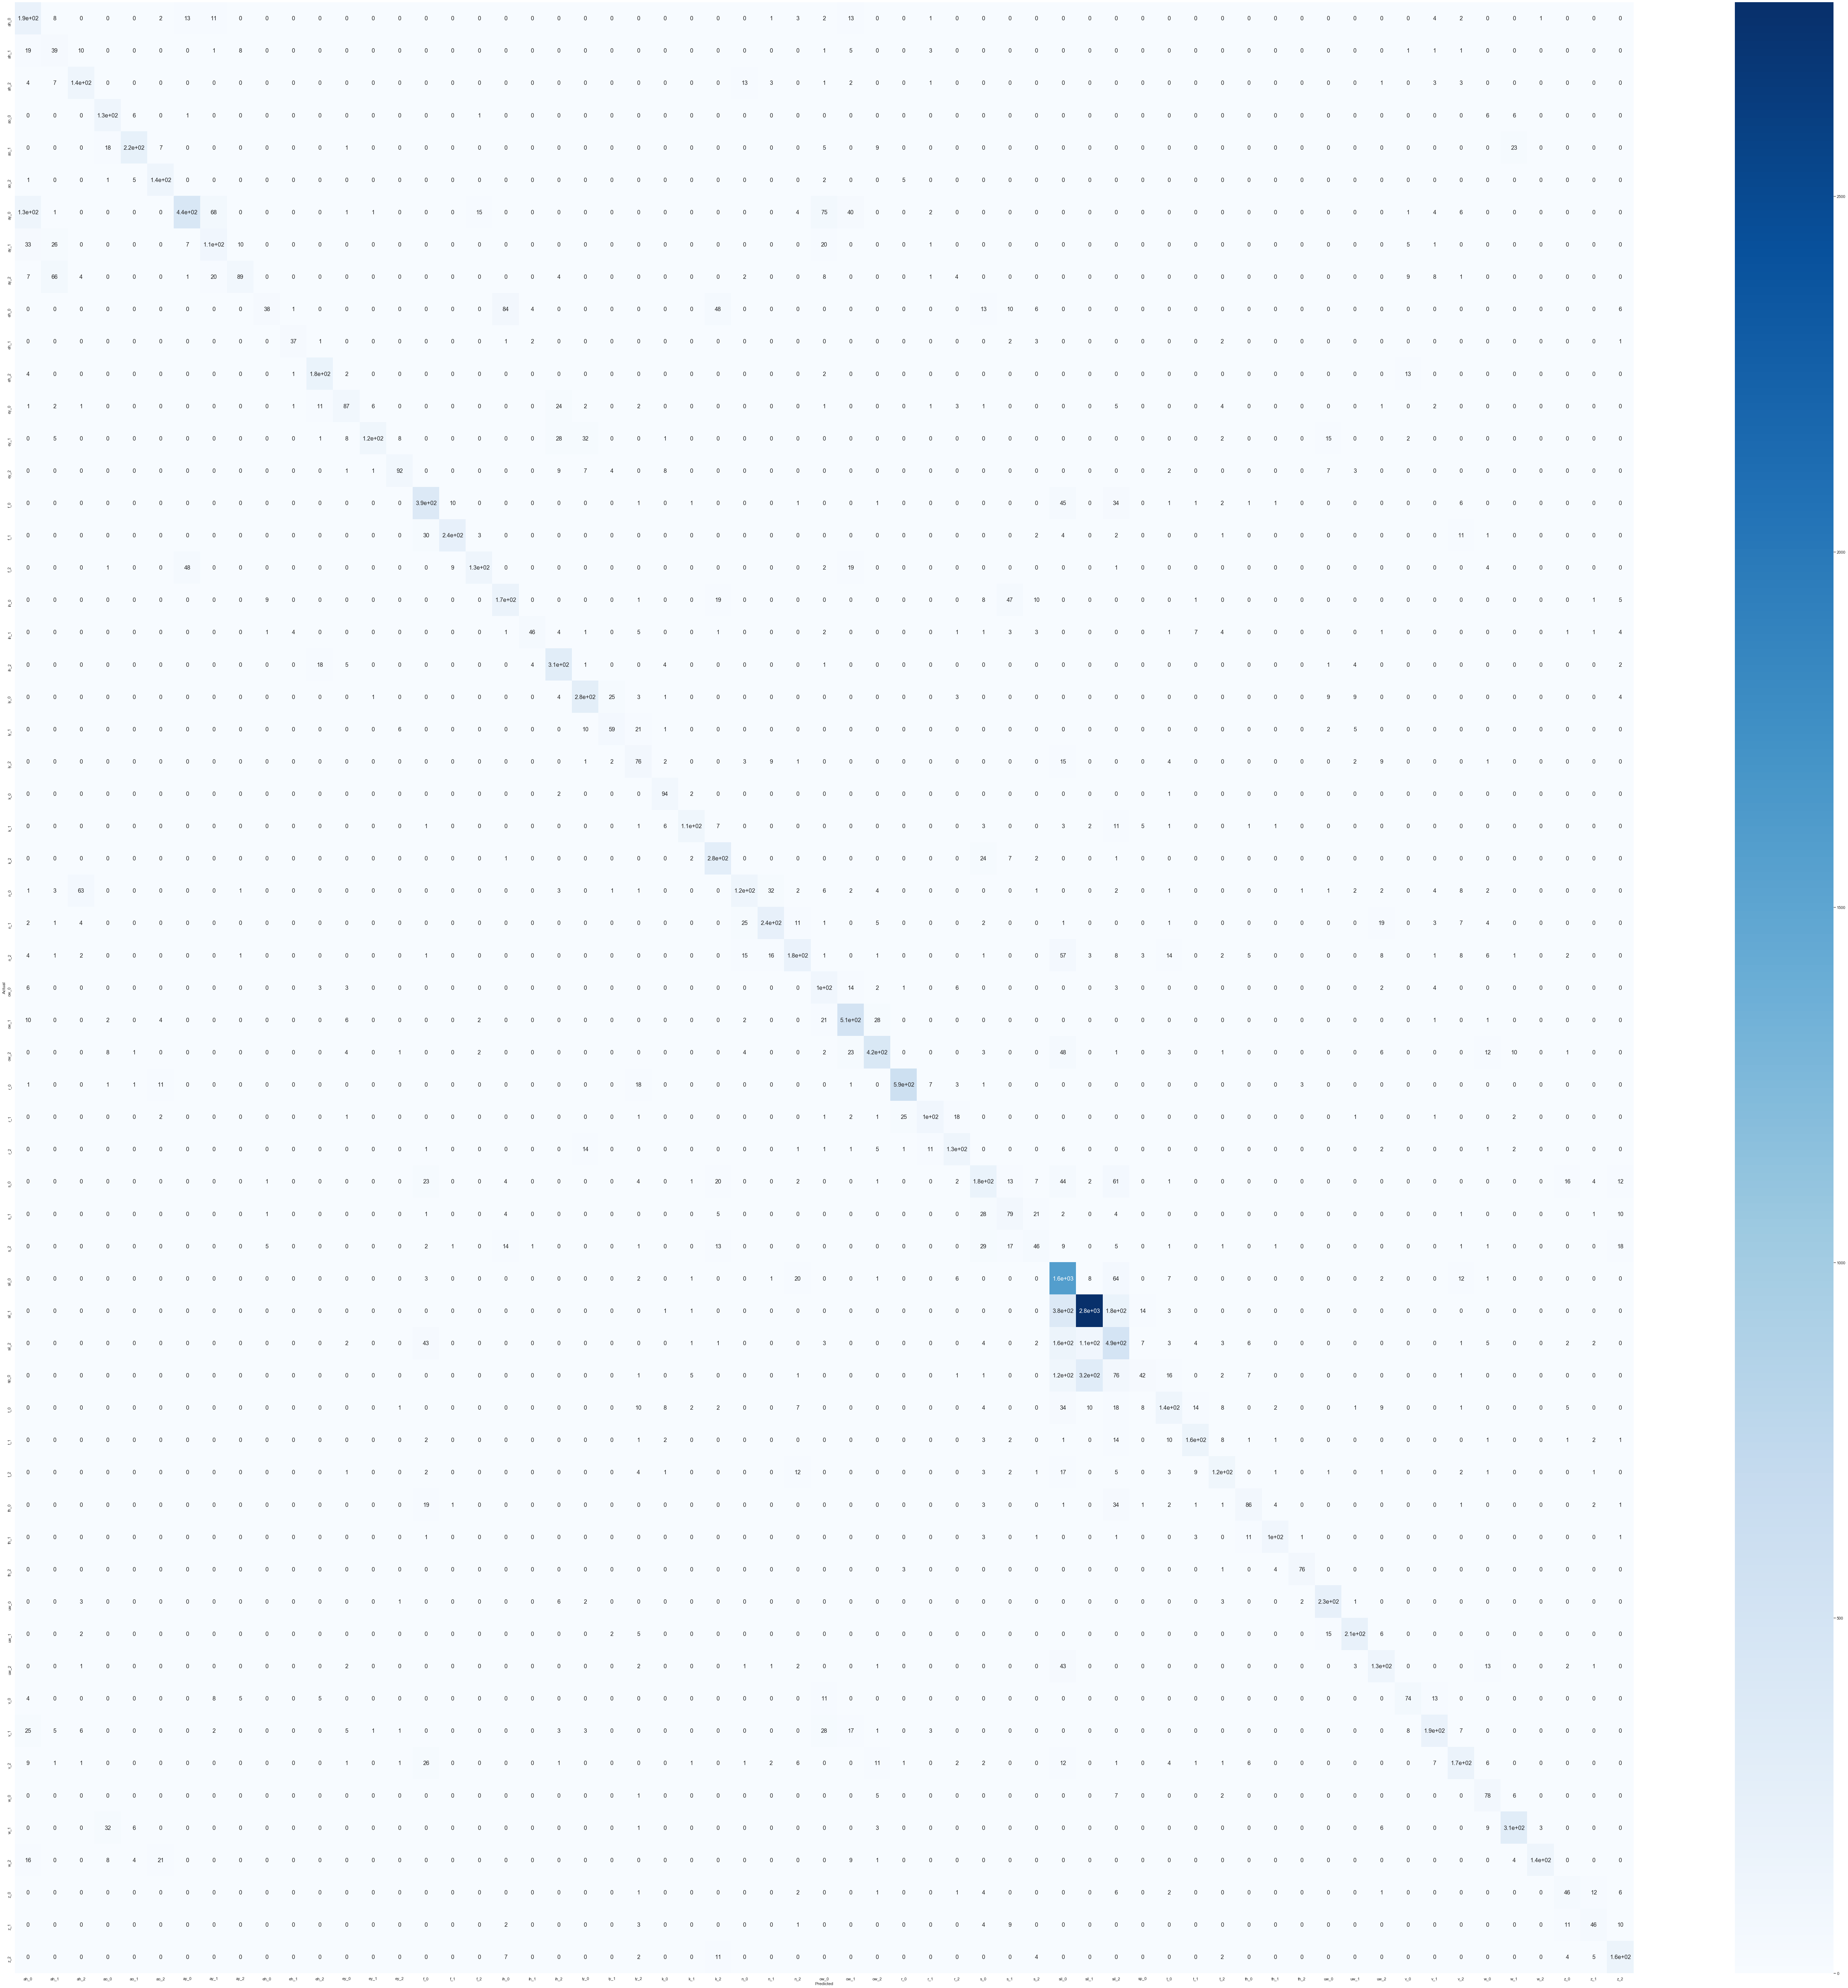

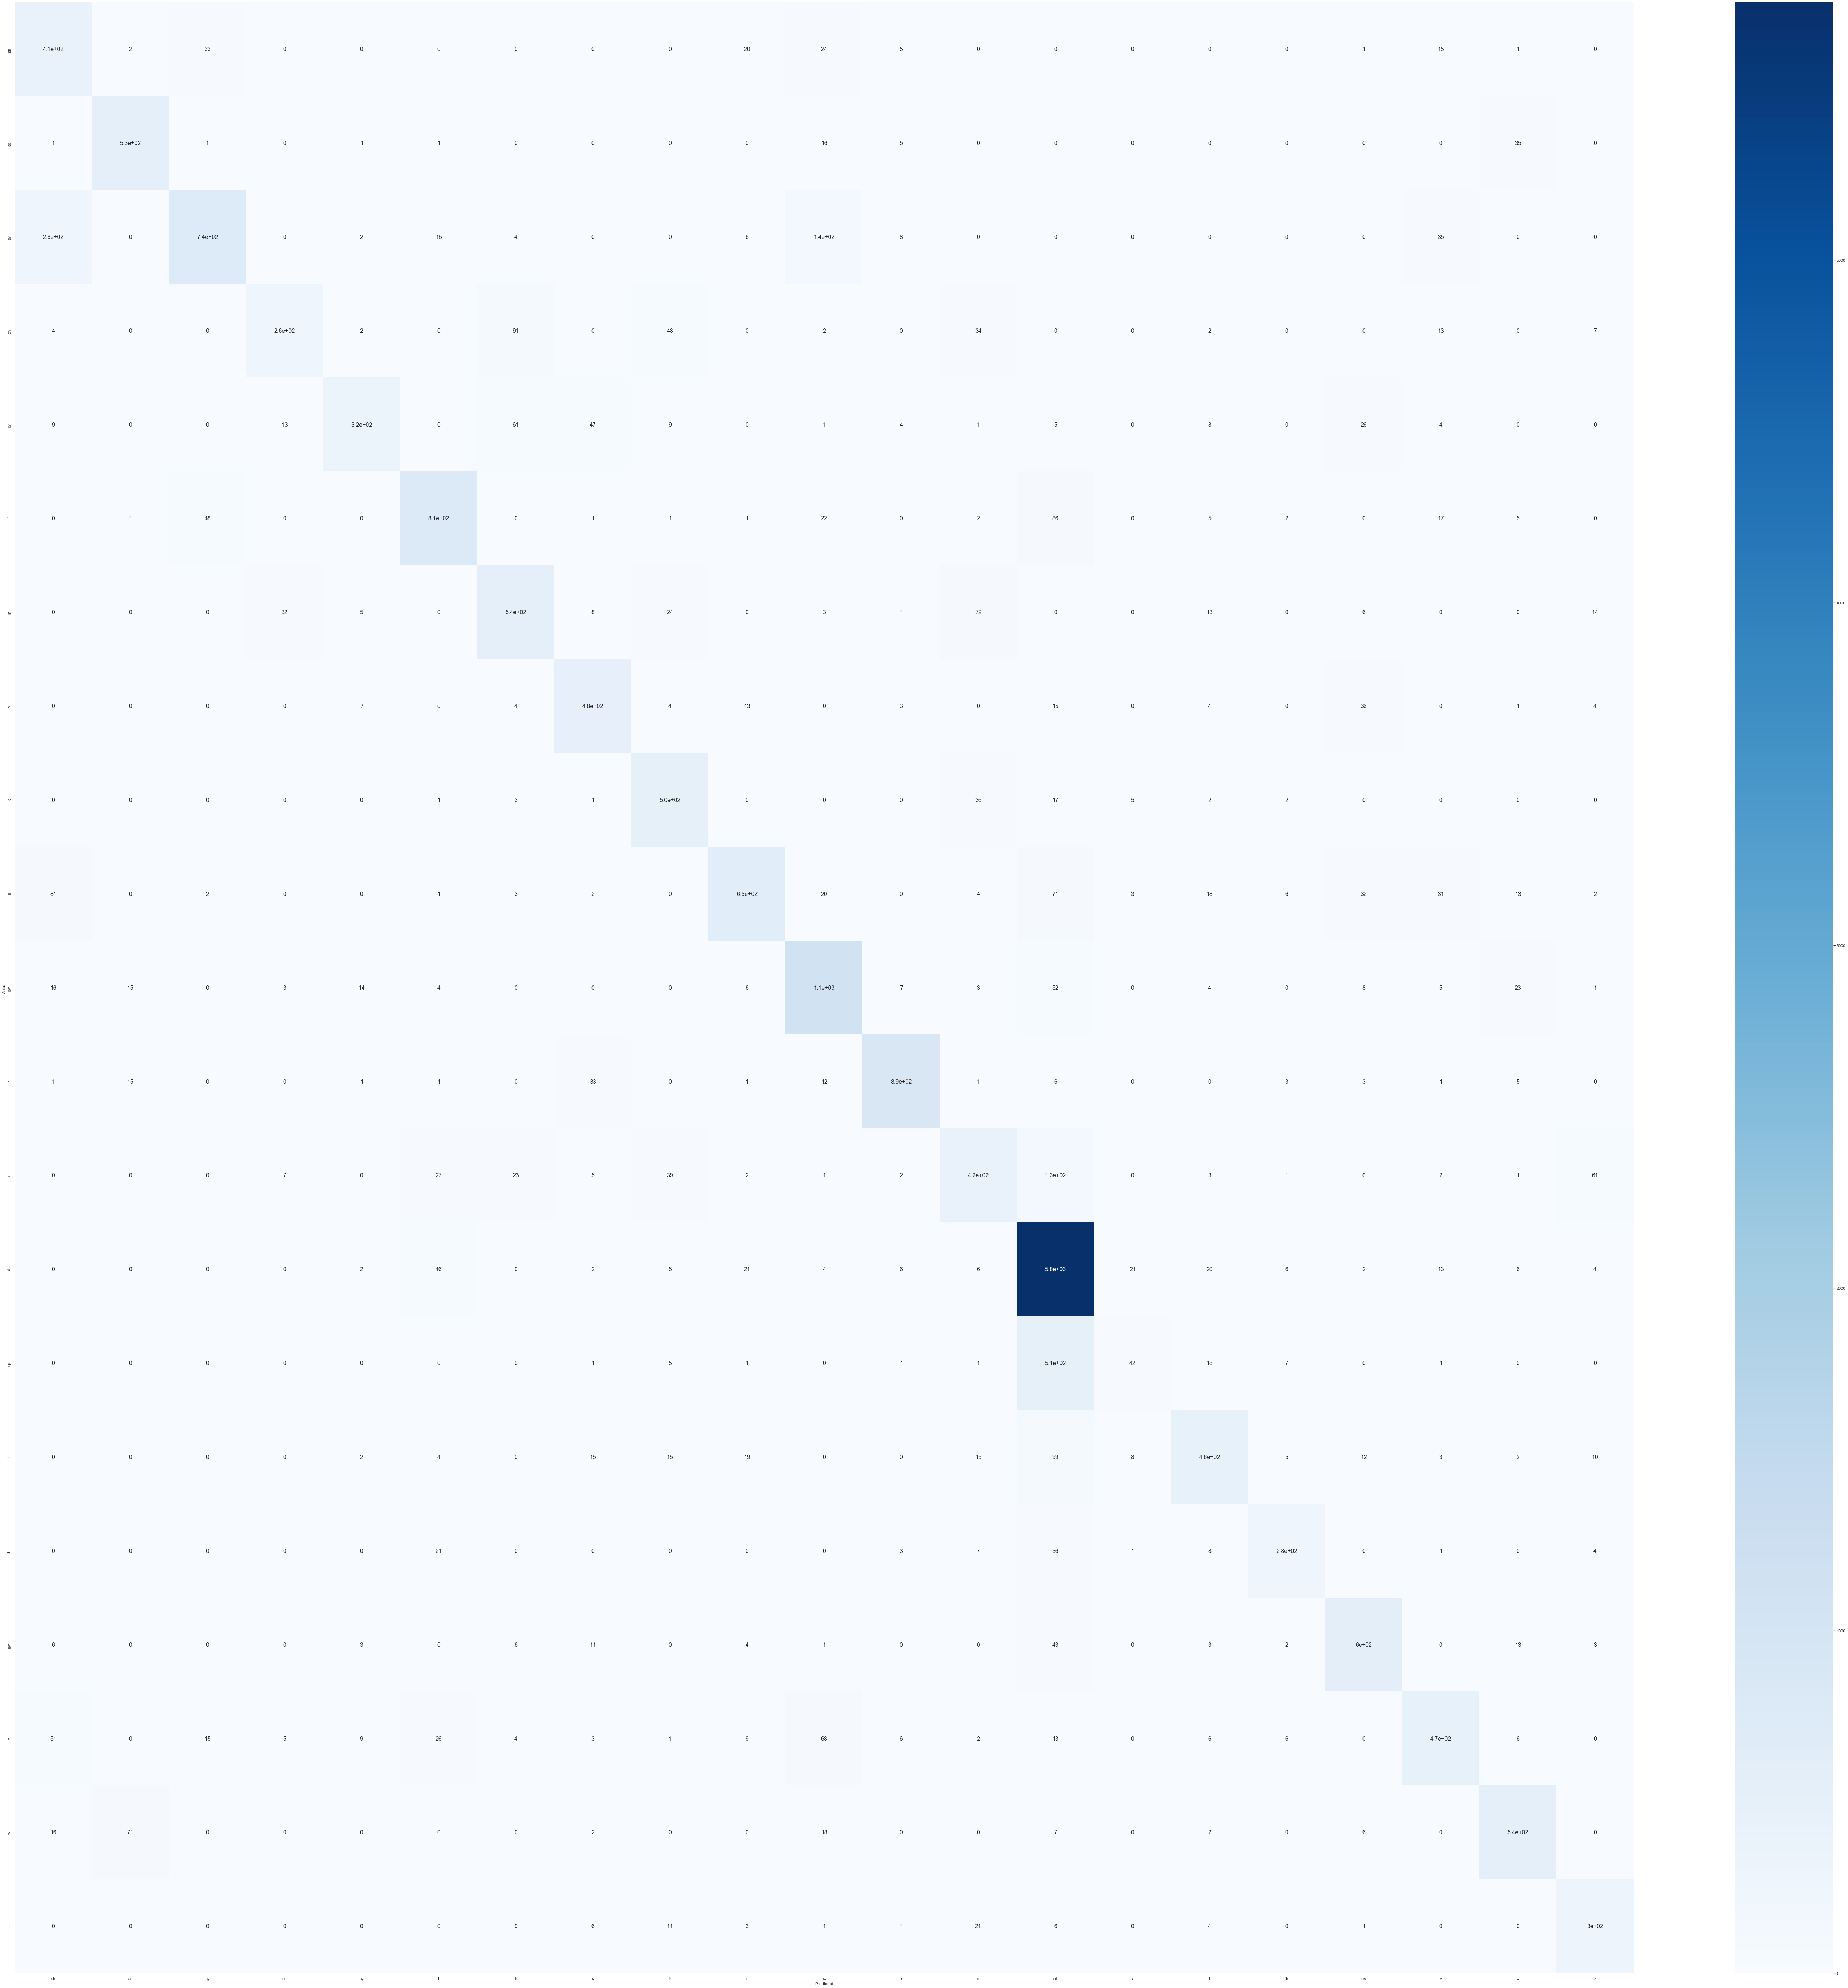

In [8]:
evauluation(3, 'dylmfcc')

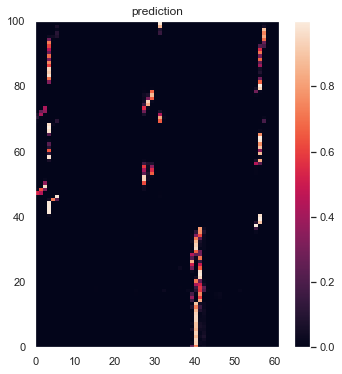

total testset size: 20000
5.1 count correct frames at frame level:
num of label: 20000
correct predict: 14656
accuracy:0.732800

5.2 merge all states the correspond to the same phoneme:
num of label at phoneme level:
num of label: 20000
num of predict: 20000
correct predict: 16298
accuract: 0.814900

5.3 edit distance at state level:
phone error rate at state level: 0.5284064665127021

5.4 edit distance at phoneme level:
phone error rate at phoneme level: 0.9071


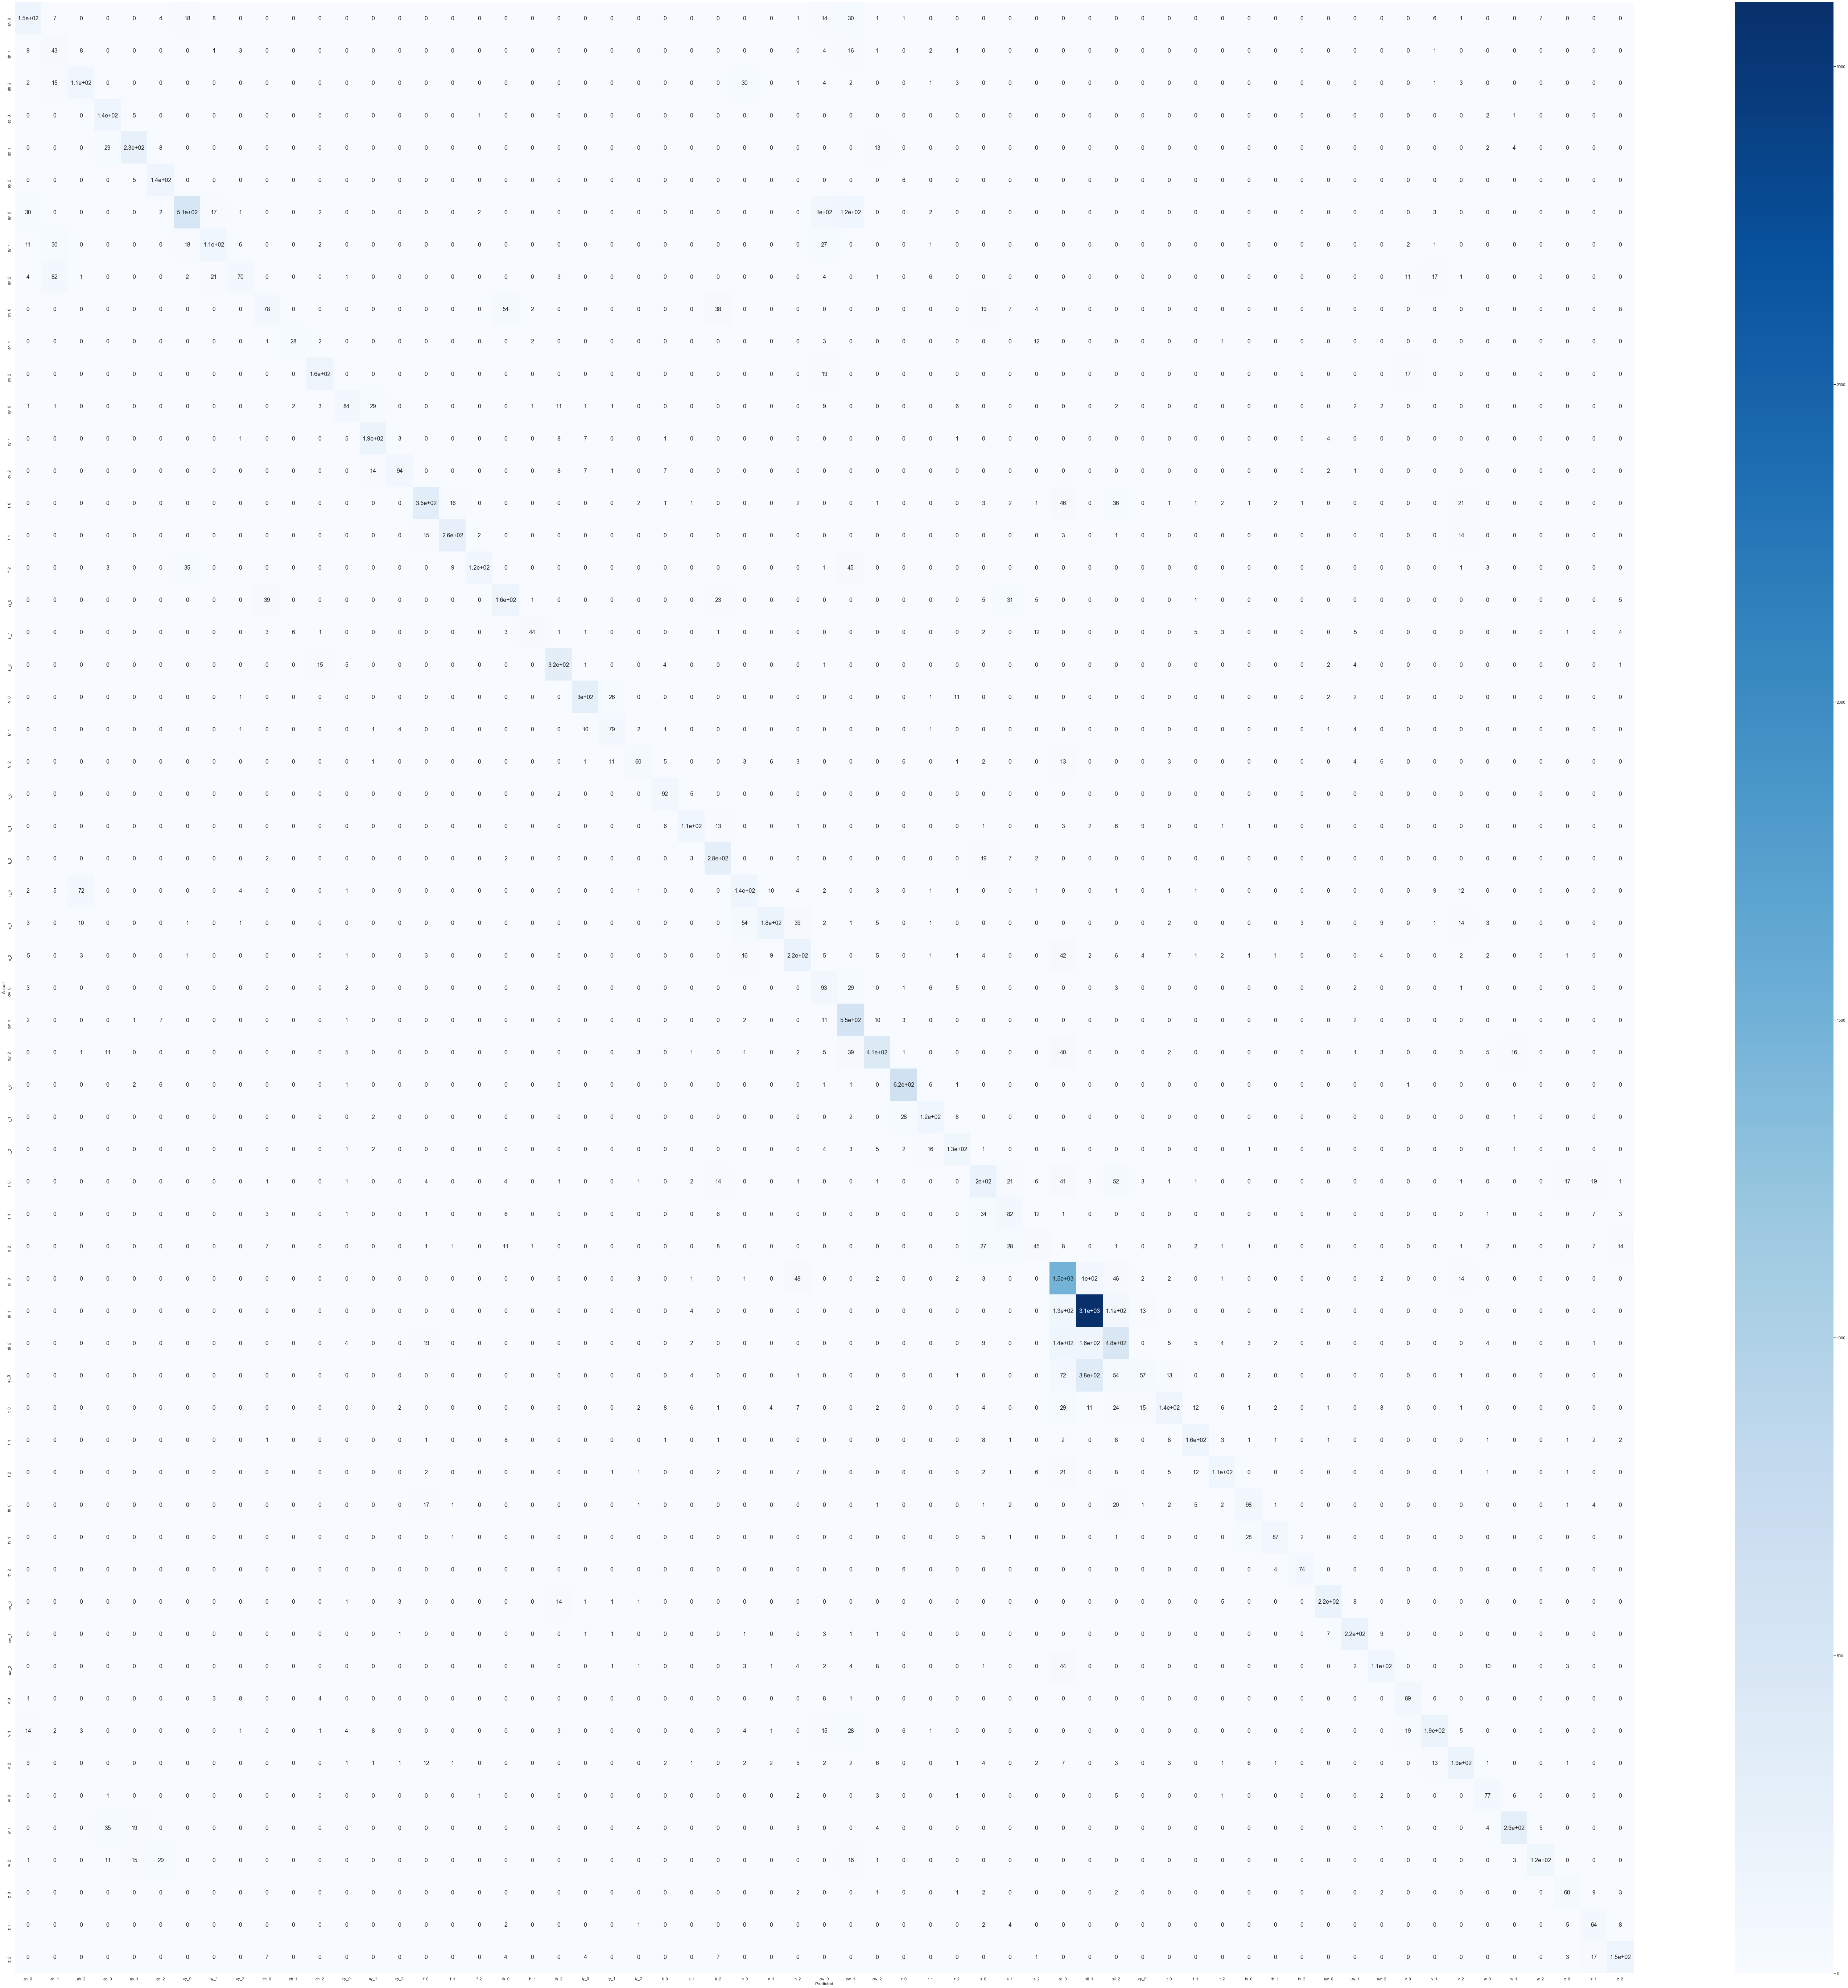

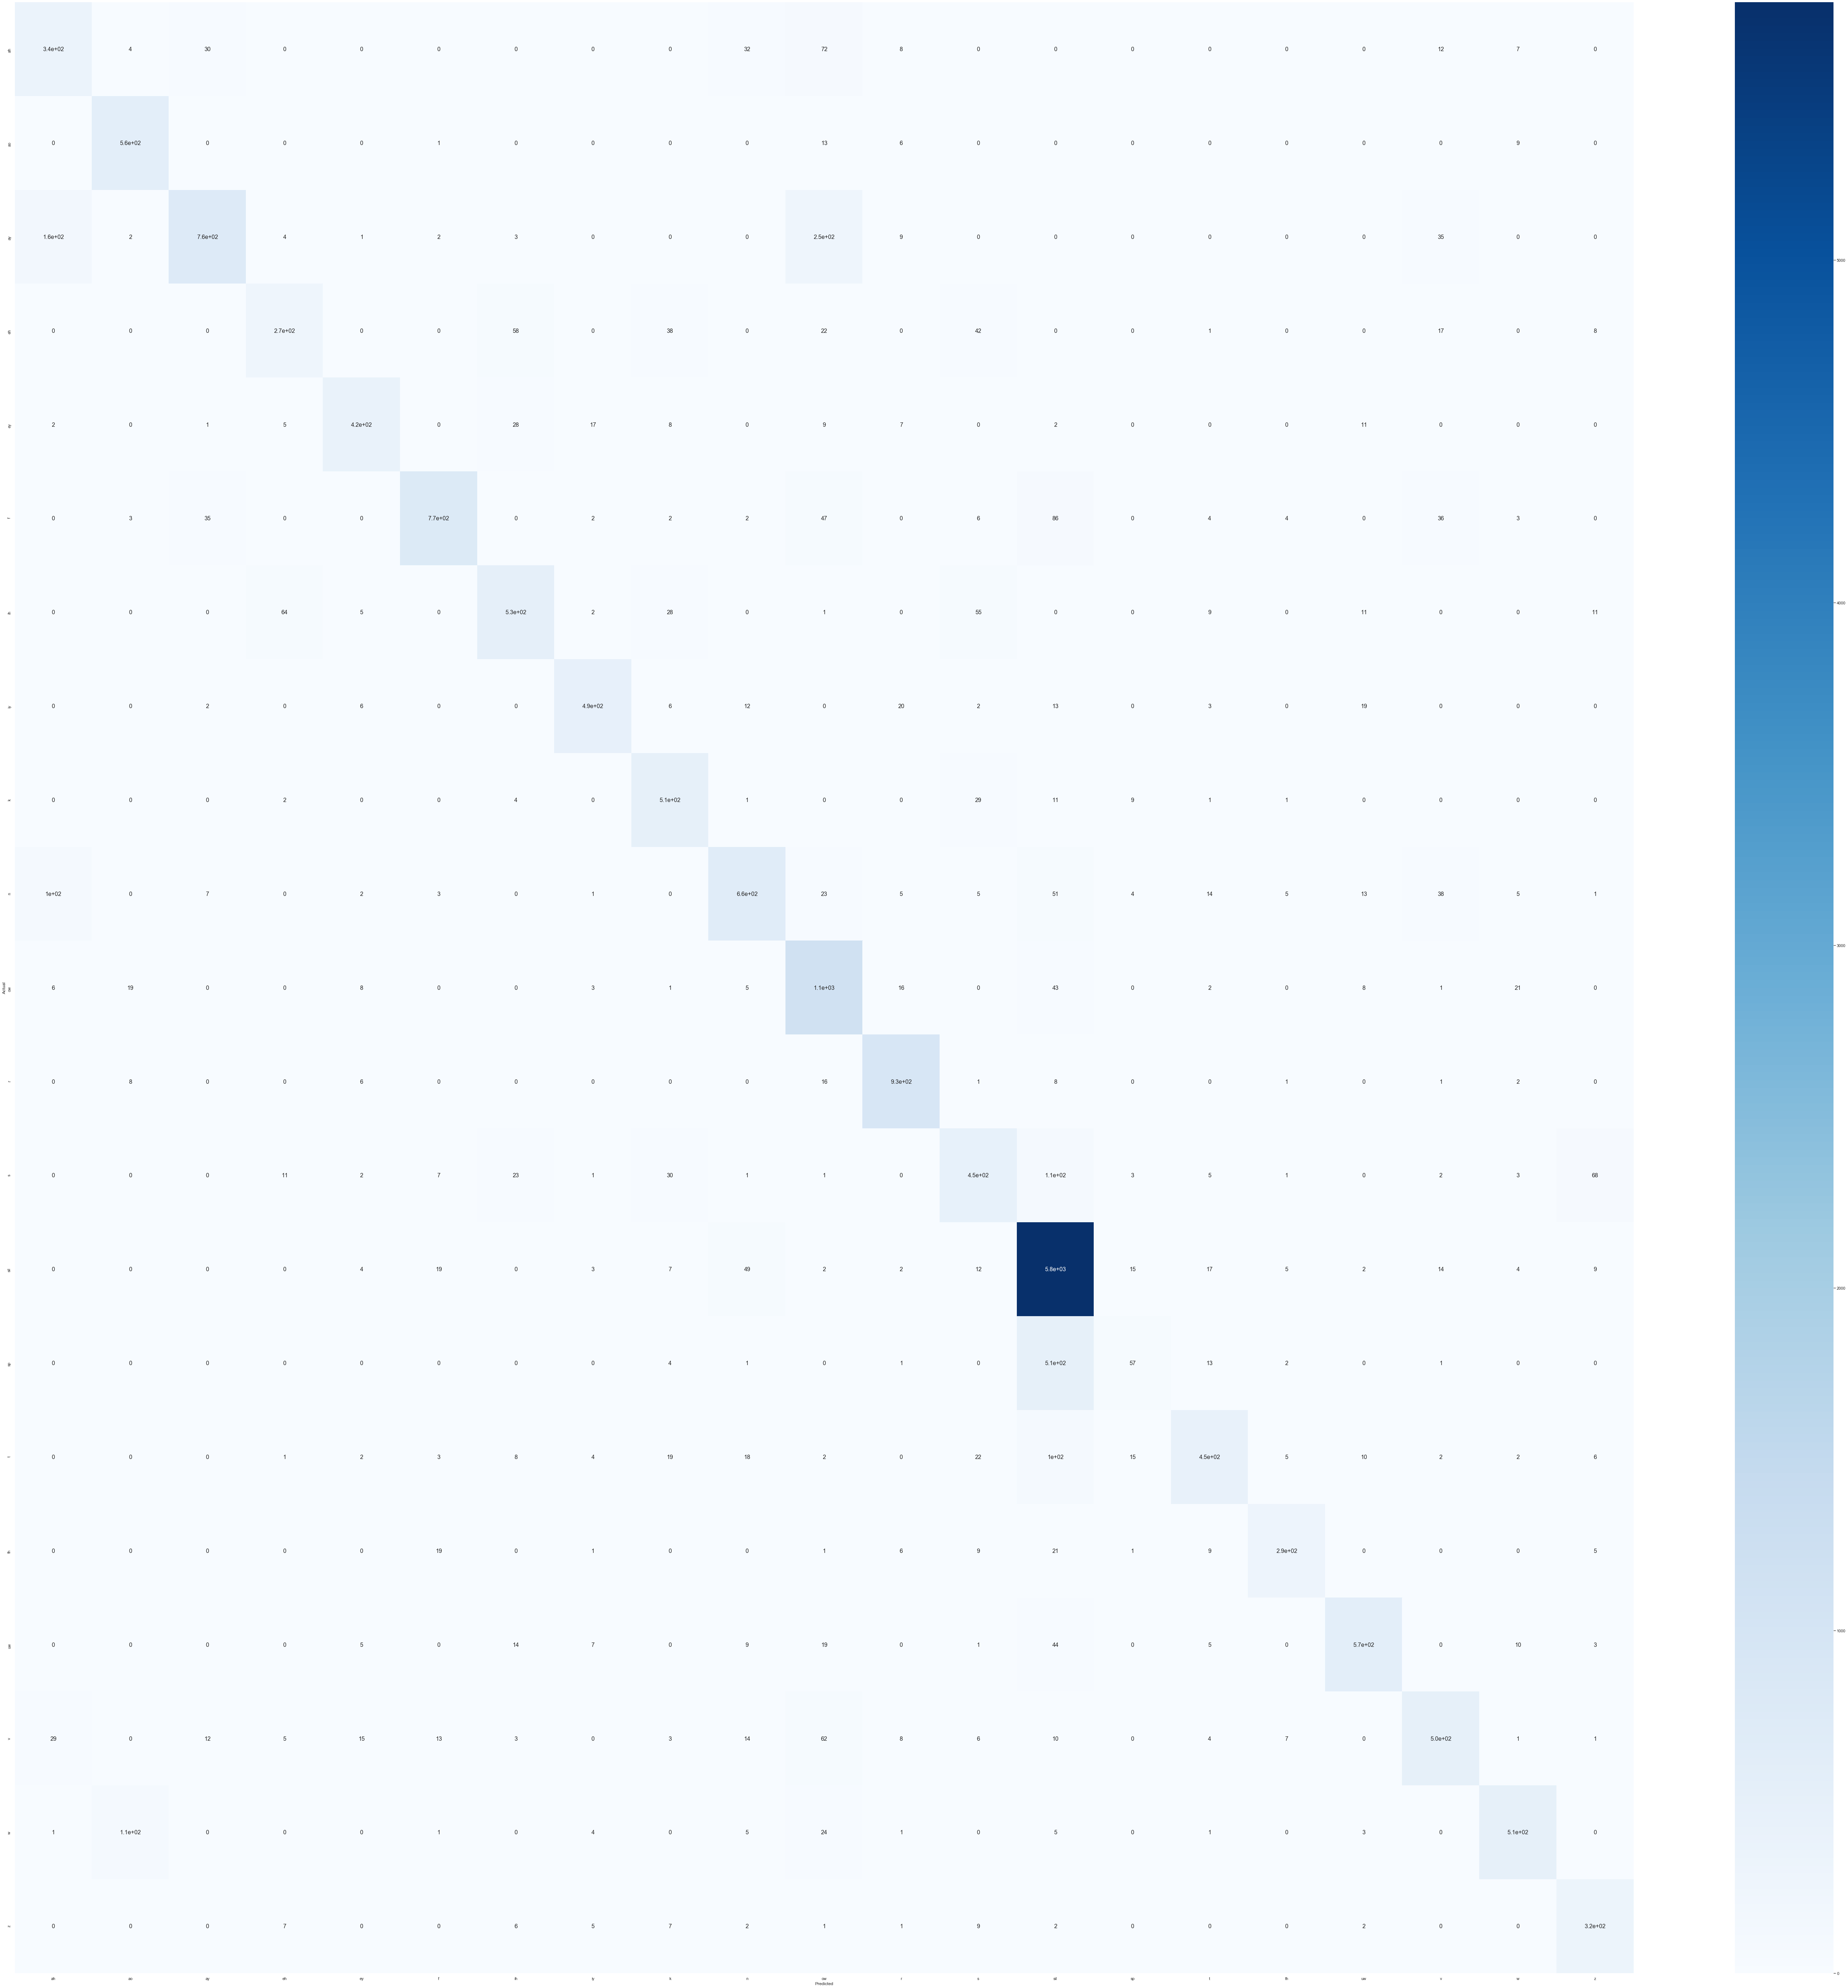

In [9]:
evauluation(4, 'dymspec')